In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import numpy as np
import xarray as xr
from glob import glob
import os
import shutil
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from multiprocessing import Pool

mpl.rcParams['figure.dpi'] = 200

In [5]:
cube = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
cube

<xarray.Dataset>
Dimensions:             (lat: 1140, lon: 1460, dayofyear: 366, fold: 6,
                         time: 7305, hour: 24)
Coordinates:
  * dayofyear           (dayofyear) int64 0 1 2 3 4 5 ... 361 362 363 364 365
  * fold                (fold) int64 0 1 2 3 4 5
  * hour                (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * lat                 (lat) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
  * lon                 (lon) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * time                (time) datetime64[ns] 2002-01-01 ... 2021-12-31
Data variables: (12/18)
    canopyheight        (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    fold_mask           (fold, lat, lon) bool dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    fvc                 (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    fvc_ano             (time, lat, lon) float32 dask.array<chunksize=(300, 20, 20), meta=np.ndarray>
    fvc_msc             (dayofyear, lat, lon) float32 dask.array<chunksize=(366, 20, 20), meta=np.ndarray>
    lst                 (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    ...                  ...
    sandfrac            (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    ssrd                (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    t2m                 (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    topidx              (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    tp                  (time, hour, lat, lon) float32 dask.array<chunksize=(300, 24, 20, 20), meta=np.ndarray>
    wtd                 (lat, lon) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>

In [3]:
def make_figure(ncols=1, center=(0, 0)):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5), subplot_kw={'projection': ccrs.Orthographic(*center)}, squeeze=False, gridspec_kw={'wspace': 0})

    for ax in axes.flat:
        # generate a basemap with country borders, oceans and coastlines
        ax.add_feature(cfeat.LAND, color='0.6')
        ax.add_feature(cfeat.OCEAN, color='0.4')
        ax.add_feature(cfeat.COASTLINE, lw=.7)
        ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.5)
        ax.set_global()
        #ax.set_extent([-100, 30, 0, 80], crs=ccrs.PlateCarree())
    return fig, axes[0, :]

def make_figure_flat(ncols=1):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(6 * ncols, 6), subplot_kw={'projection': ccrs.Mollweide()}, gridspec_kw={'wspace': 0}, squeeze=False)

    for ax in axes.flat:
        # generate a basemap with country borders, oceans and coastlines
        ax.add_feature(cfeat.LAND, color='0.6')
        #ax.add_feature(cfeat.OCEAN, color='0.4')
        ax.add_feature(cfeat.COASTLINE, lw=.7)
        ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.3)
        ax.set_global()
        ax.set_extent([-120, 150, -58, 90], crs=ccrs.PlateCarree())
        ax.spines['geo'].set_visible(False)
        ax.patch.set_visible(False)
    return fig, axes[0, :]

def plot_t(ds_t, vmin, vmax, title, save_dir=None, dpi=200, cmap='BrBG', levels=None, rotate=0, globe=True, t=False, is_hourly=True, **kwargs):

    if isinstance(ds_t, xr.DataArray):
        if not isinstance(vmin, (int, float, str)):
            raise TypeError('`vmin` must be numeric or a string.')
        if not isinstance(vmax, (int, float, str)):
            raise TypeError('`vmax` must be numeric or a string.')
        if not isinstance(title, str):
            raise TypeError('`title` must be a string.')
        if not isinstance(title, str):
            raise TypeError('`cmap` must be a string.')
        ds_t = [ds_t]
        vmin = [vmin]
        vmax = [vmax]
        title = [title]
        cmap = [cmap]
    else:
        if not isinstance(vmin, list):
            raise TypeError('`vmin` must be a list as multiple datasets were passed.')
        if not isinstance(vmax, list):
            raise TypeError('`vmax` must be a list as multiple datasets were passed.')
        if not isinstance(title, list):
            raise TypeError('`title` must be a list as multiple datasets were passed.')
        if not isinstance(cmap, list):
            raise TypeError('`cmap` must be a list as multiple datasets were passed.')

    extends = []
    vmins = []
    vmaxs = []

    for mn, mx in zip(vmin, vmax):
        if isinstance(mn, str):
            if isinstance(mx, str):
                extends.append('both')
            else:
                extends.append('min')
        else:
            if isinstance(mx, str):
                extends.append('max')
            else:
                extends.append('neither')
            
        vmins.append(float(mn))
        vmaxs.append(float(mx))


    num_ds = len(ds_t)

    if globe:
        fig, axes = make_figure(num_ds, center=(rotate % 360, 0))
    else:
        fig, axes = make_figure_flat(num_ds)

    for i, ax in enumerate(axes):

        if levels is None:
            img = ds_t[i].plot.imshow(
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=True,
                vmin=vmins[i],
                vmax=vmaxs[i],
                cmap=cmap[i],
                cbar_kwargs=dict(
                    orientation='horizontal', pad=0.0, shrink=0.5, label='', aspect=60, extend=extends[i]
                ),
                **kwargs
            )
        else:
            img = ds_t[i].plot.contourf(
                levels=levels,
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=True,
                vmin=vmins[i],
                vmax=vmaxs[i],
                cmap=cmap,
                cbar_kwargs=dict(
                    orientation='horizontal', pad=0.0, shrink=0.5, label='', aspect=60, extend=extends[i]
                ),
                **kwargs
            )

        if is_hourly:
            time = ds_t[i].time.dt.strftime("%Y-%m-%d-%H").item()
        else:
            time = ds_t[i].time.dt.strftime("%Y-%m-%d").item()

        if globe:
            cbax = inset_axes(ax,
                        width="100%",  # width = 50% of parent_bbox width
                        height="100%",  # height : 5%
                        loc='lower center',
                        bbox_to_anchor=(0.28, 0.12, 0.45, 0.02) if globe else (0.32, 0.0, 0.5, 0.02),
                        bbox_transform=ax.transAxes)
            img.colorbar.remove()         
            cbar = fig.colorbar(img, cax=cbax, orientation='horizontal', extend=extends[i])
            cbar.ax.set_title(f'{title[i]} – {time}', size=11)
            cbar.ax.tick_params(labelsize=11)
        else:
            img.colorbar.ax.set_title(f'{title[i]} – {time}', size=11, pad=0)
            img.colorbar.ax.tick_params(labelsize=11)

        #cbar.ax.xaxis.set_tick_params(color='w')
        #cbar.outline.set_edgecolor('w')
        #plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')

        ax.set_title('')
        #ax.text(0.3, 0.3, f'{title} – {time}', transform=ax.transAxes, color='w')

    # fig.tight_layout()

    if save_dir is None:
        return img
    else:
        if i is None:
            path = os.path.join(save_dir, f'frame_{time}.png')
        else:
            path = os.path.join(save_dir, f'frame_{t:05d}.png')

        fig.savefig(path, dpi=dpi, bbox_inches='tight', transparent=True)
        plt.close(fig)
        del ds_t, img, ax, title

def animate(
        ds, vmin, vmax, title, save_path, timerange=-1, levels=None,
        globe=True, rotate_speed=0, dpi=150, cmap='BrBG', fps=15, ncpus=1, use_pil=False,
        png_out=False):

    tmpdir = tempfile.mkdtemp(dir=os.path.dirname(save_path))

    if isinstance(ds, xr.Dataset):
        raise TypeError('must pass an xr.DataArray, not an xr.Dataset.')
    elif isinstance(ds, xr.DataArray):
        if not isinstance(vmin, (int, float, str)):
            raise TypeError('`vmin` must be numeric or a string.')
        if not isinstance(vmax, (int, float, str)):
            raise TypeError('`vmax` must be numeric or a string.')
        if not isinstance(title, str):
            raise TypeError('`title` must be a string.')
        if not isinstance(cmap, str):
            raise TypeError('`cmap` must be a string.')

        ntime = len(ds.time)

    else:
        if not isinstance(vmin, list):
            raise TypeError('`vmin` must be a list as multiple datasets were passed.')
        if not isinstance(vmax, list):
            raise TypeError('`vmax` must be a list as multiple datasets were passed.')
        if not isinstance(title, list):
            raise TypeError('`title` must be a list as multiple datasets were passed.')
        if not isinstance(cmap, list):
            raise TypeError('`cmap` must be a list as multiple datasets were passed.')

        ntime = len(ds[0].time)

    if timerange == -1:
        timerange = range(ntime)
    elif isinstance(timerange, int):
        timerange = range(timerange)

    if isinstance(ds, list):
        timedim = ds[0]['time']
    else:
        timedim = ds['time']

    is_hourly = xr.infer_freq(timedim) == 'H'

    try:

        time_chunks = ds.chunksizes['time']
        time_chunks = np.lib.stride_tricks.sliding_window_view(np.concatenate((np.zeros(1), np.cumsum(time_chunks))), 2)
        time_chunks = time_chunks.astype('int')

        for time_chunk in time_chunks:
            ds_buffer = ds.isel(time=slice(*time_chunk)).load()

            par_kwargs = [{
                'ds_t': ds_buffer.isel(time=t) if isinstance(ds_buffer, xr.DataArray) else [ds_buffer[i].isel(time=t) for i in range(len(ds))],
                'vmin': vmin,
                'vmax': vmax,
                'title': title,
                'save_dir': tmpdir,
                'dpi': dpi,
                'cmap': cmap,
                'levels': levels,
                'rotate': t * rotate_speed,
                'globe': globe,
                't': time_chunk[0] + t,
                'is_hourly': is_hourly
            } for t in range(time_chunk[1] - time_chunk[0])]

            par_args = [list(el.values()) for el in par_kwargs]

            # parcall(plot_t, ds_args, dry_run=False, num_cpus=ncpus, vmin=vmin, vmax=vmax, levels=levels,
            #     globe=globe, save_dir=tmpdir, title=title, cmap=cmap, dpi=dpi);

            with Pool(processes=min(len(par_args), ncpus)) as pool:
                pool.starmap(plot_t, par_args)

            fp_in = os.path.join(tmpdir, 'frame*.png')
            paths = sorted(glob(fp_in))

        if not png_out:
            file_path = os.path.join(os.path.dirname(save_path), f'{title.lower()}.gif') 
            command = f'convert -delay {100 / fps} -loop 0 {" ".join(paths)} {file_path}'
            #command = f'{ffmpeg_path} -y -threads 16 -framerate {fps} -pattern_type glob -i \'{fp_in}\' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p {save_path}.webm'
            os.system(command)
            print('Done.')

        else:
            if os.path.isdir(save_path):
                shutil.rmtree(save_path)
            os.rename(tmpdir, save_path)
            print('Done.')
    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

        


In [4]:
animate(
    cube.fvc_ano.sel(time='2005'), vmin=-0.2, vmax=0.2, title='FVC',
    cmap='RdBu',
    save_path='./anim/fvc', timerange=100, rotate_speed=0,# 360 / (365 * 2),
    ncpus=40, dpi=200, fps=10, png_out=False)

KeyboardInterrupt: 

In [33]:
animate(
    [fvc.FVC, vod_asc.VOD, vod_dec.VOD], vmin=[0.0, 0.0, 0.0], vmax=[1.0, 3.0, 3.0], title=['FVC', 'VOD asc', 'VOD des'],
    cmap=['BrBG', 'BrBG', 'BrBG'],
    save_path='./anim/vod', timerange=-1, rotate_speed=0,# 360 / (365 * 2),
    ncpus=20, dpi=200, fps=10, use_pil=True)

NameError: name 'fvc' is not defined

In [12]:
xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/SEVIRI/0d10_daily/MDLST/Data/LST.1460.1140.01.2005.nc').LST

<xarray.DataArray 'LST' (time: 744, latitude: 1140, longitude: 1460)>
[1238313600 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01T00:00:00.000040 ... 2005-01-3...
  * longitude  (longitude) float64 -74.45 -74.35 -74.25 ... 71.25 71.35 71.45
  * latitude   (latitude) float64 76.45 76.35 76.25 ... -37.25 -37.35 -37.45
Attributes:
    long_name:  fraction
    units:      -

In [4]:
d = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/t2m.hourly.1460.1140.2018.nc')
d

<xarray.Dataset>
Dimensions:    (time: 8760, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
  * longitude  (longitude) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 31 16:03:36 2022: ncrcat -4 -O --cnk_plc g2d --cnk_...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

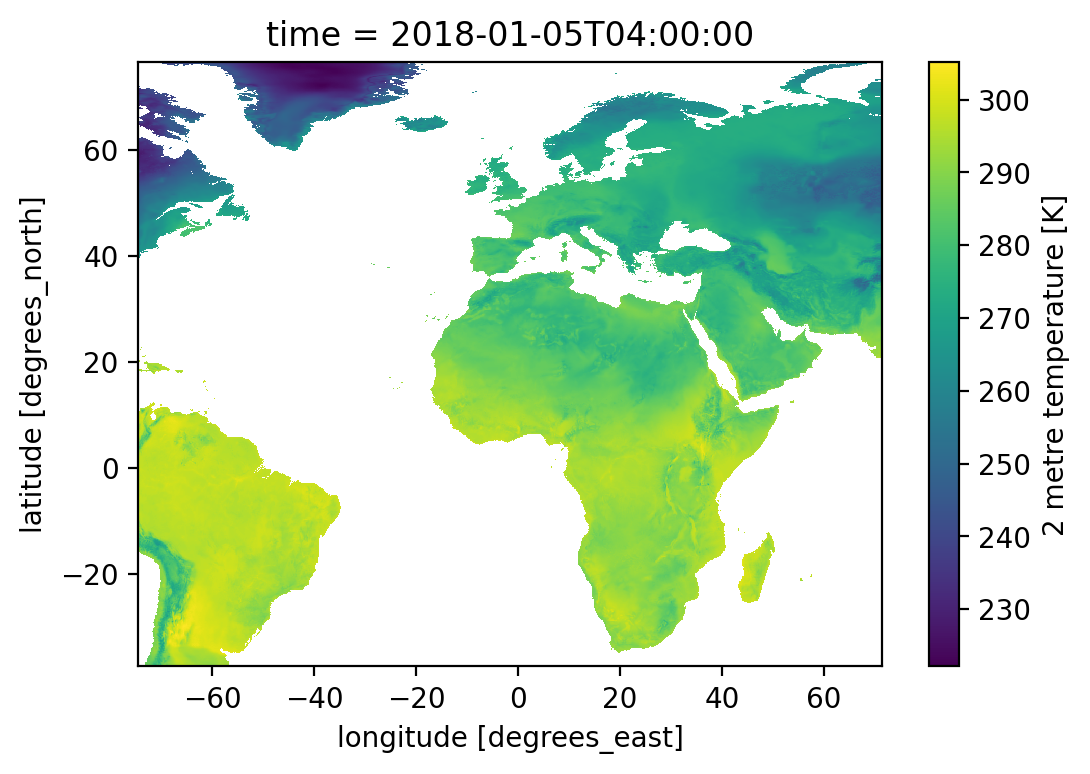

In [8]:
d.t2m.isel(time=100).plot()

In [8]:
d.t2m.plot.hist(bins=100);

In [8]:
fvc = xr.open_mfdataset([f'/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/SEVIRI/0d10_daily/MDFVC/Data/LST.1460.1140.{m:02d}.2004.nc' for m in range(1, 13)])
fvc

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01T00:00:00.000040 ... 2004-12-3...
  * longitude  (longitude) float64 -74.45 -74.35 -74.25 ... 71.25 71.35 71.45
  * latitude   (latitude) float64 76.45 76.35 76.25 ... -37.25 -37.35 -37.45
Data variables:
    LST        (time, latitude, longitude) float32 dask.array<chunksize=(31, 1140, 1460), meta=np.ndarray>
Attributes:
    title:                         Fraction of Vegetation Cover product deriv...
    version:                       no-version-given
    reference:                     Trigo, I. F., C. C. DaCamara, P. Viterbo, ...
    provided_by:                   FVC has been provided by the EUMETSAT Sate...
    url:                           http://lsa-saf.eumetsat.int
    history:                       created: Mon May 16 08:17:16 2022
    created_by:                    uweber@bgc-jena.mpg.de
    spatial_interpolation_method:  bilinear

In [10]:
animate(
    fvc.LST, vmin=0, vmax=1, title='FVC',
    cmap='BrBG',
    save_path='./anim/fvc', timerange=-1, rotate_speed=0,# 360 / (365 * 2),
    ncpus=40, dpi=200, fps=10, use_pil=True)

2022-05-30 16:31:08 - Parallel execution of function `plot_t` using 40 CPUs with 366 total runs.


(remote_fun pid=35765) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=35786) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=35770) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=35757) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=35769) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incom

2022-05-30 16:36:26 - Done, elapsed time: 5 m 18 s (0 m 0 s per call).
ffmpeg -y -threads 16 -framerate 10 -pattern_type glob -i './anim/tmpgl_9_s_4/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ./anim/fvc.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


In [22]:
lst = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/SEVIRI/0d10_daily/MDLST/Data/LST.1460.1140.06.2006.nc')

In [18]:
animate(
    lst.LST, vmin=-35, vmax=35, title='LST',
    cmap='coolwarm',
    save_path='./anim/lst', timerange=-1, rotate_speed=0,# 360 / (365 * 2),
    ncpus=40, dpi=200, fps=10, use_pil=True)

2022-05-19 09:43:38 - Parallel execution of function `plot_t` using 40 CPUs with 744 total runs.


(remote_fun pid=6939) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6942) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6935) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6954) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6931) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatib

2022-05-19 09:45:35 - Done, elapsed time: 1 m 56 s (0 m 0 s per call).
ffmpeg -y -threads 16 -framerate 10 -pattern_type glob -i './anim/tmpjnret33p/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ./anim/lst.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


frame=  744 fps=3.2 q=0.0 Lsize=   17610kB time=00:01:14.30 bitrate=1941.6kbits/s speed=0.318x    
video:17498kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.640693%


In [19]:
lst.LST.isel(time=301)

<xarray.DataArray 'LST' (latitude: 1140, longitude: 1460)>
[1664400 values with dtype=float32]
Coordinates:
    time       datetime64[ns] 2005-01-13T13:00:00.000027
  * longitude  (longitude) float64 -74.45 -74.35 -74.25 ... 71.25 71.35 71.45
  * latitude   (latitude) float64 76.45 76.35 76.25 ... -37.25 -37.35 -37.45
Attributes:
    long_name:  fraction
    units:      -

In [23]:
lst.LST.isel(time=301).min()

<xarray.DataArray 'LST' ()>
array(-112.54999542)
Coordinates:
    time     datetime64[ns] 2005-01-13T13:00:00.000027

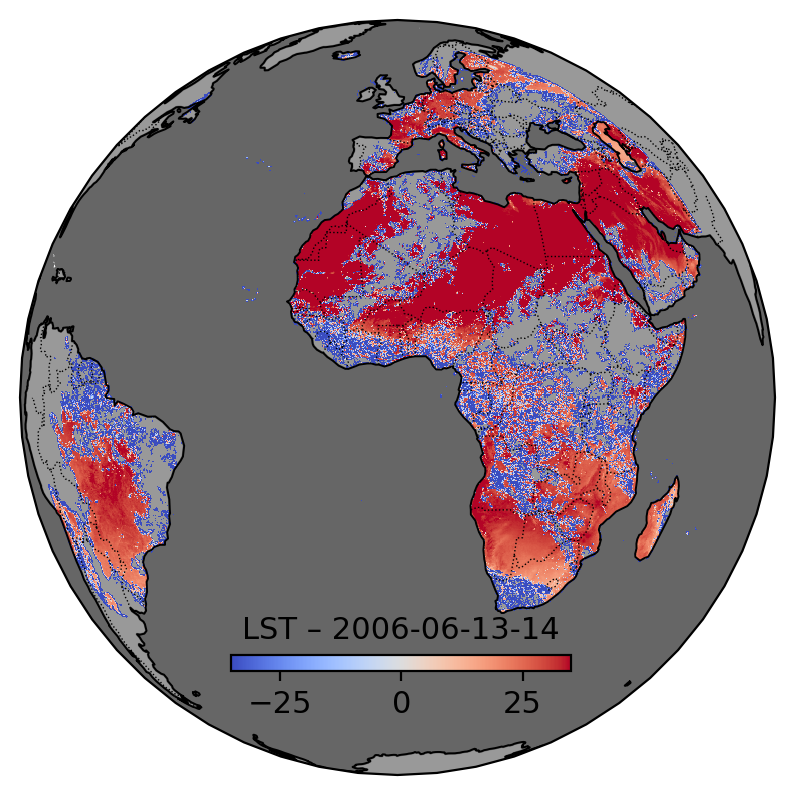

In [23]:
plot_t(lst.LST.isel(time=302), -35, 35, 'LST', cmap='coolwarm')

In [21]:
fvc.lat[1] - fvc.lat[0]

<xarray.DataArray 'lat' ()>
array(-0.04166667)

In [ ]:
def get_msc(x):
    msc = x.groupby('time.dayofyear').mean()
    msc_0 = msc.copy().assign_coords(dayofyear=np.arange(1-366, 1))
    msc_1 = msc.copy().assign_coords(dayofyear=np.arange(367, 367+366))
    msc_stack = xr.concat((msc_0, msc, msc_1), dim='dayofyear')
    msc_stack = msc_stack.rolling(dayofyear=7, min_periods=4, center=True).median()
    msc_smooth = msc_stack.rolling(dayofyear=41, min_periods=21, center=True).mean().sel(dayofyear=slice(1, 366))

    return msc, msc_smooth

In [281]:
def precomp(x):
    return x[['VOD']].sel(latitude=50, longitude=10, method='nearest').load()

ds = xr.open_mfdataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d25_daily/AMSRE/LPDR_V3/Data/VOD/asc/VOD.ascending.AMSRE_LPDR_V2.qa_remove_7.1440.720.365.*.nc', preprocess=precomp, parallel=True)

In [282]:
ds

<xarray.Dataset>
Dimensions:    (time: 5110)
Coordinates:
  * time       (time) datetime64[ns] 2002-01-01T00:00:00.000040 ... 2019-12-3...
    longitude  float64 10.12
    latitude   float64 50.12
Data variables:
    VOD        (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:        VOD
    version:      AMSR2_LPDR_V3
    reference:    Du et al. A global satellite environmental data record deri...
    history:      created: Wed Dec  8 10:24:11 2021
    provided_by:  jinyang.du@ntsg.umt.edu, The University of Montana, Missoul...
    created_by:   uweber@bgc-jena.mpg.de
    source:       http://files.ntsg.umt.edu/data/LPDR_v2/GeoTIFF
    pass:         ascending

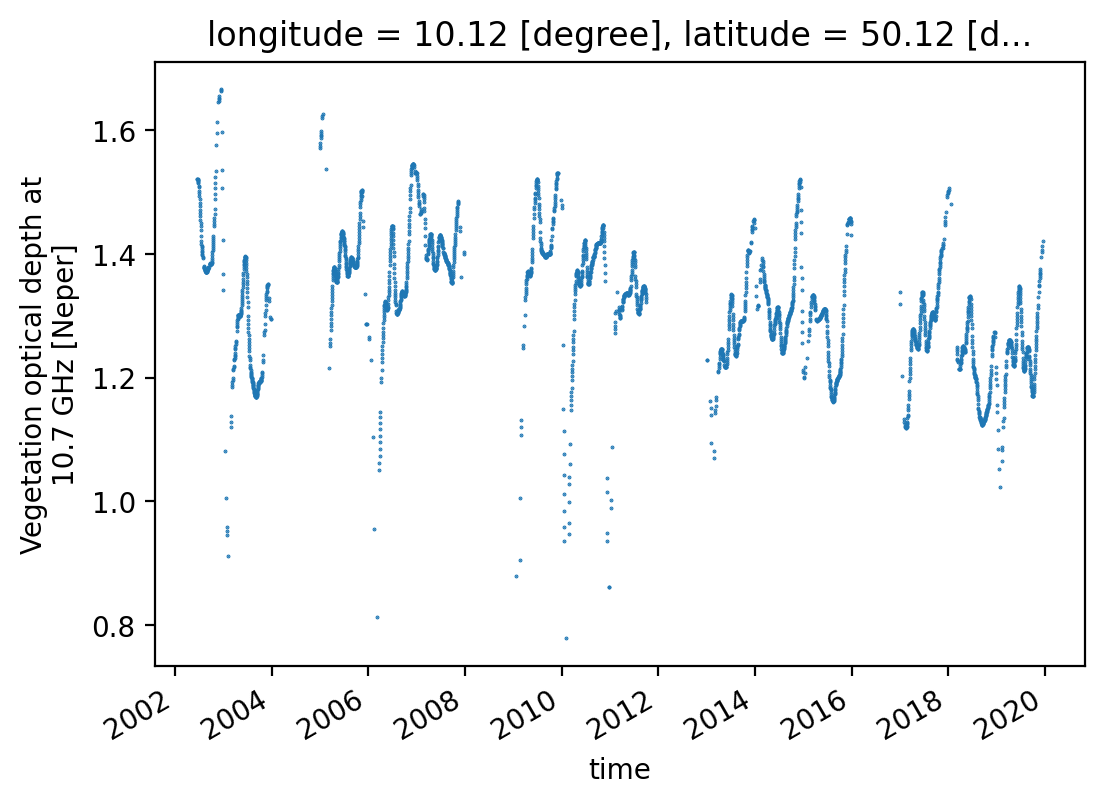

In [283]:
ds.VOD.plot(ls='none', marker='o', markersize=0.4)

In [21]:
sif = xr.open_dataset('./TROPOSIF_L2B_2021-12-01.nc', group='PRODUCT')

In [29]:
sif

<xarray.Dataset>
Dimensions:        (time: 1, n_elem: 3052443)
Coordinates:
  * time           (time) datetime64[ns] 2021-12-01
Dimensions without coordinates: n_elem
Data variables:
    delta_time     (n_elem) datetime64[ns] ...
    SIF_743        (n_elem) float32 ...
    SIF_Corr_743   (n_elem) float32 ...
    SIF_ERROR_743  (n_elem) float32 ...
    SIF_735        (n_elem) float32 ...
    SIF_Corr_735   (n_elem) float32 ...
    SIF_ERROR_735  (n_elem) float32 ...
    latitude       (n_elem) float32 -87.0 -87.07 -87.05 ... 22.15 22.17 22.11
    longitude      (n_elem) float32 37.05 35.2 37.49 ... -159.5 -159.4 -159.7

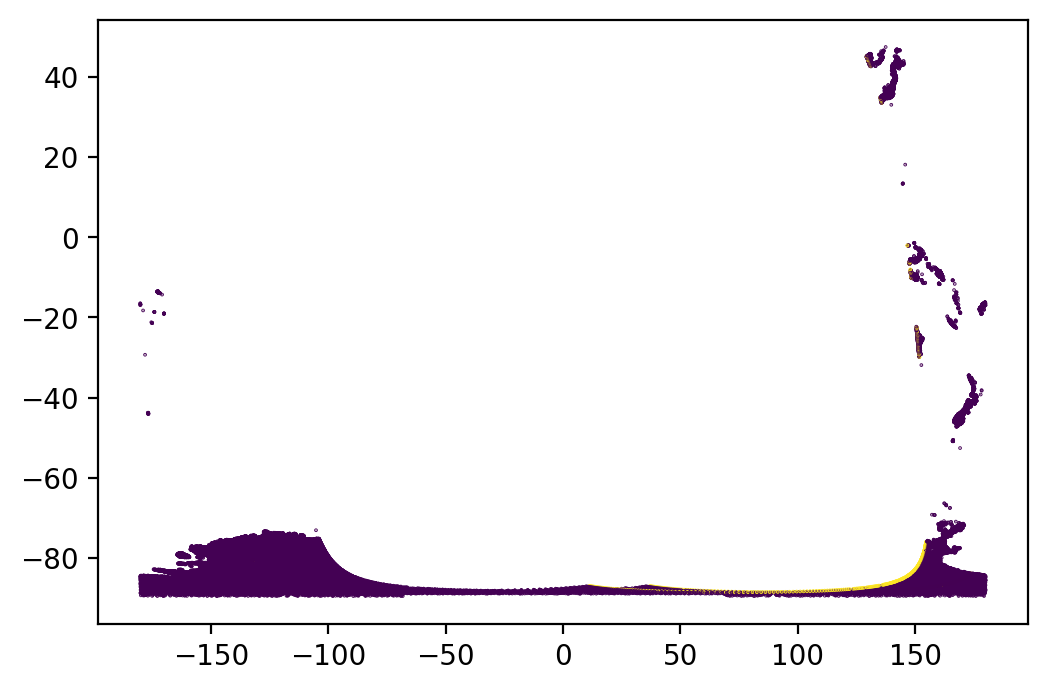

In [31]:
plt.scatter(sif.longitude[:100000], sif.latitude[:100000], s=0.1, c=sif.SIF_735[:100000])

In [2]:
import xarray as xr

In [3]:
ds = xr.open_dataset('/scratch/bkraft/data/seviri/FVC.1460.1140.2004.2019.nc')
ds

<xarray.Dataset>
Dimensions:    (time: 5844, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2019-12-31
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    FVC        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                           Climate Data Interface version 2.0.4 (http...
    Conventions:                   CF-1.6
    title:                         Fractional Vegetation Cover product derive...
    version:                       no-version-given
    reference:                     Trigo, I. F., C. C. DaCamara, P. Viterbo, ...
    provided_by:                   FVC and MTFVC were provided by the EUMETSA...
    url:                           http://lsa-saf.eumetsat.int
    history:                       Wed Mar 16 14:50:25 2022: cdo mergetime /s...
    created_by:                    uweber@bgc-jena.mpg.de
    spatial_interpolation_method:  near
    CDO:                           Climate Data Operators version 2.0.4 (http...

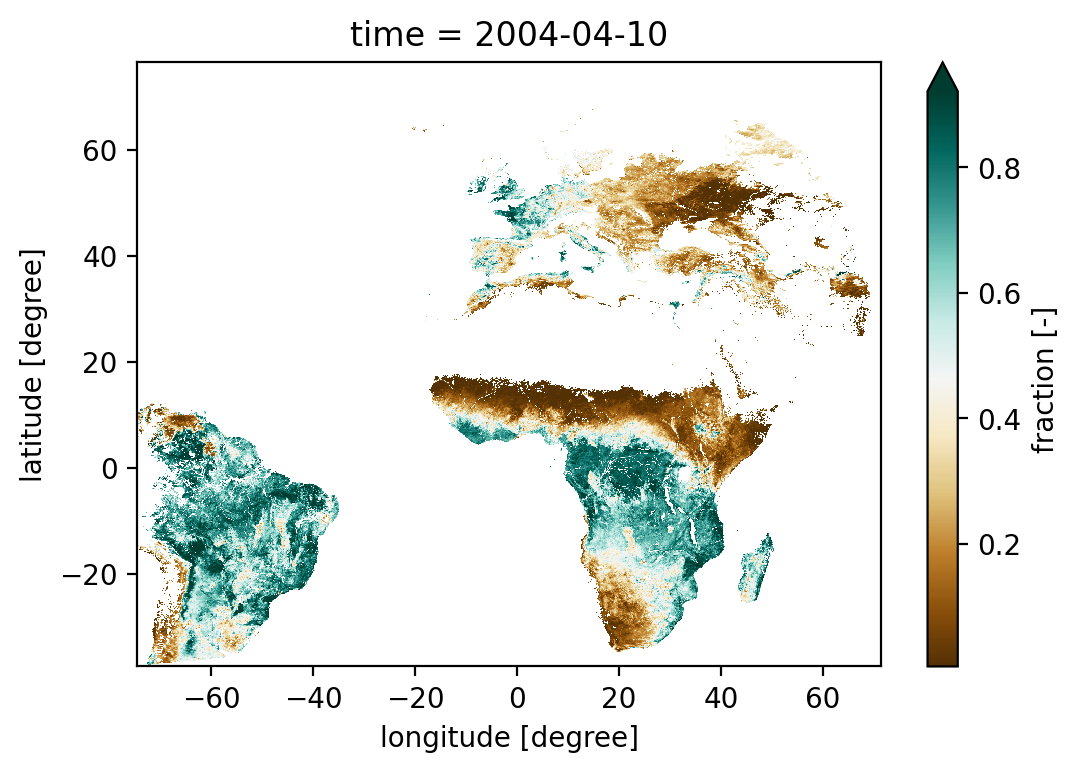

In [6]:
ds.FVC.isel(time=100).plot(robust=True, cmap='BrBG')

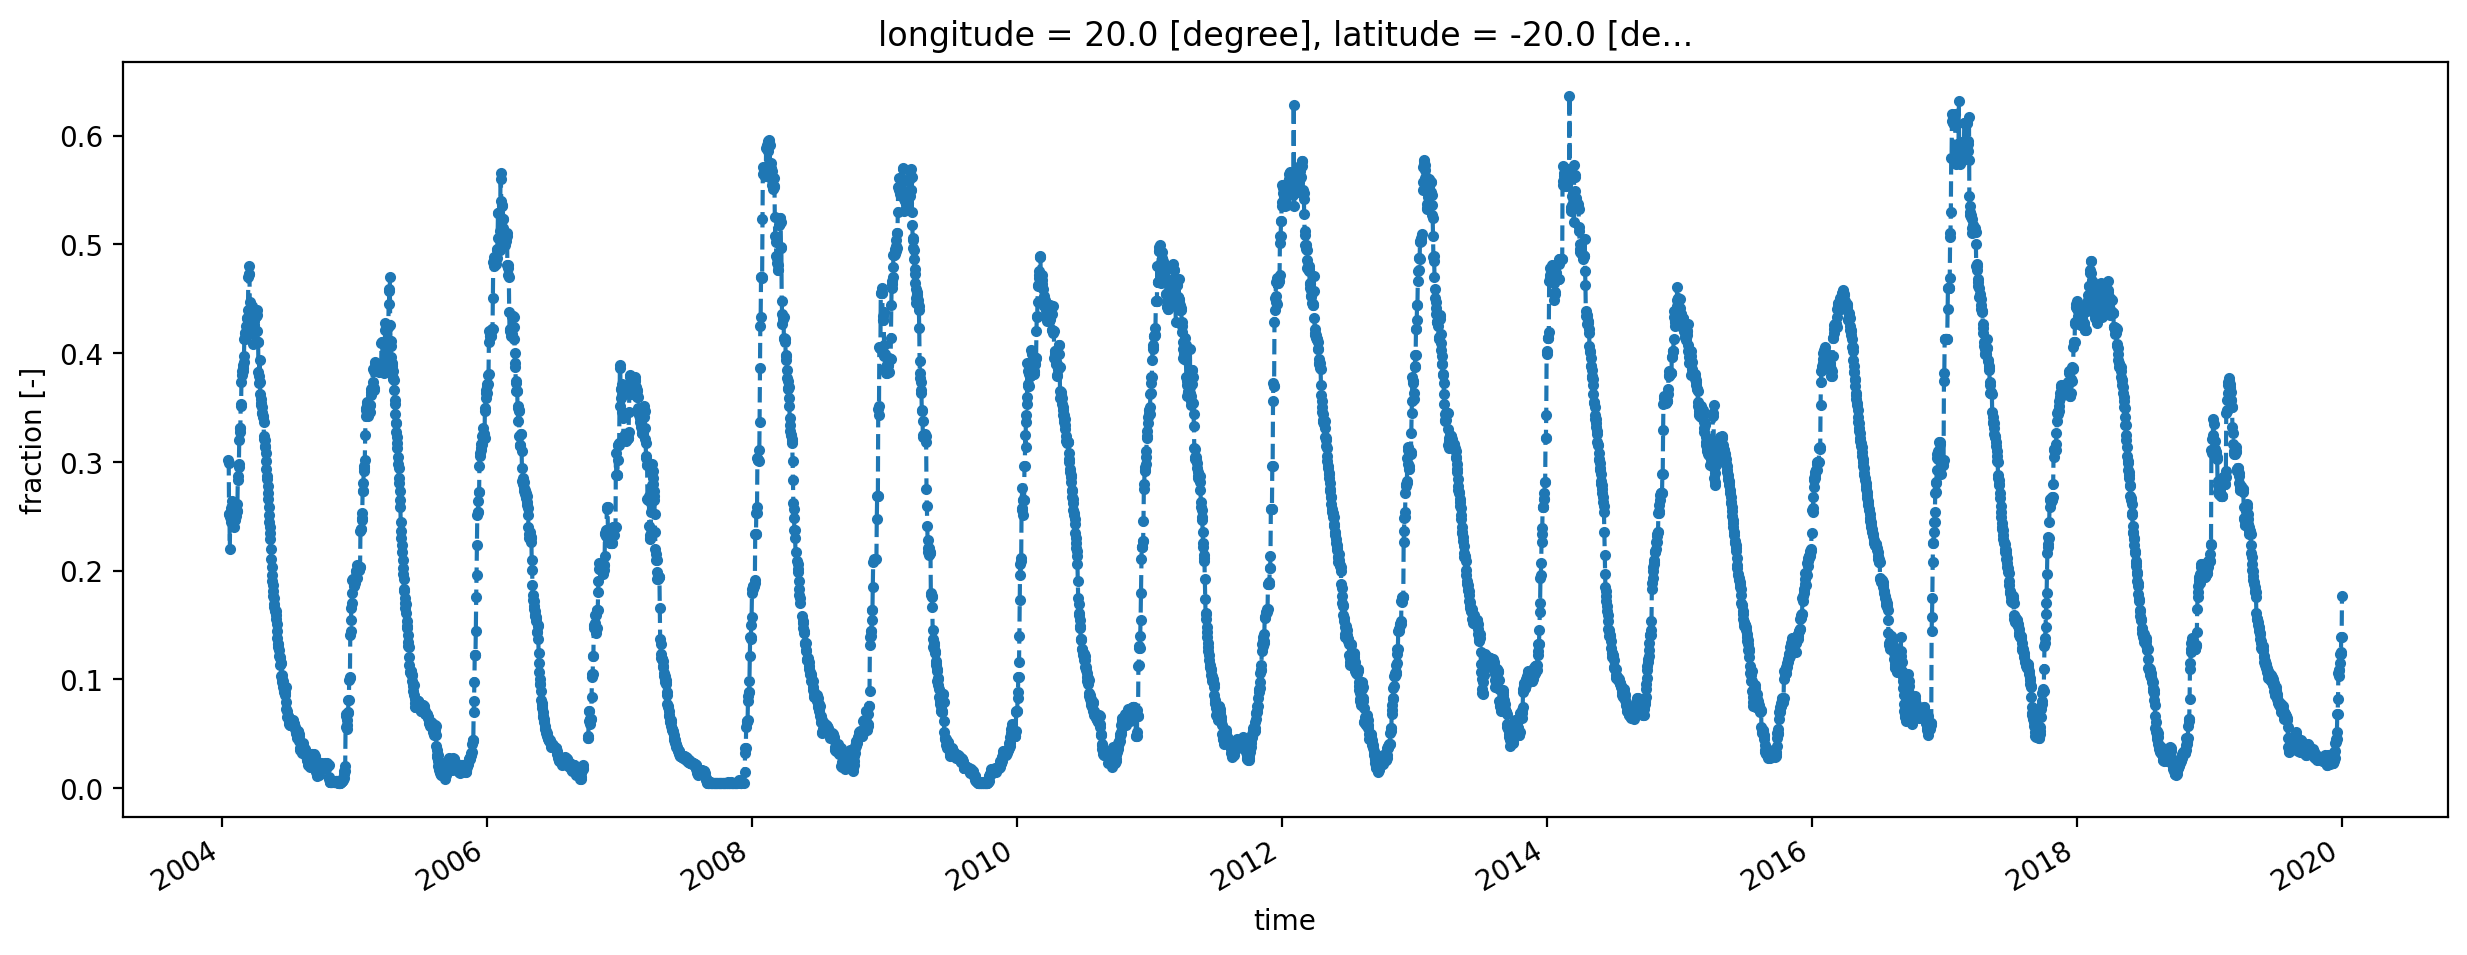

In [16]:
ds.FVC.sel(latitude=-20, longitude=20, method='nearest').plot.line('.--', figsize=(15, 5))

In [23]:
x = ds.FVC.sel(latitude=-20, longitude=20, method='nearest')

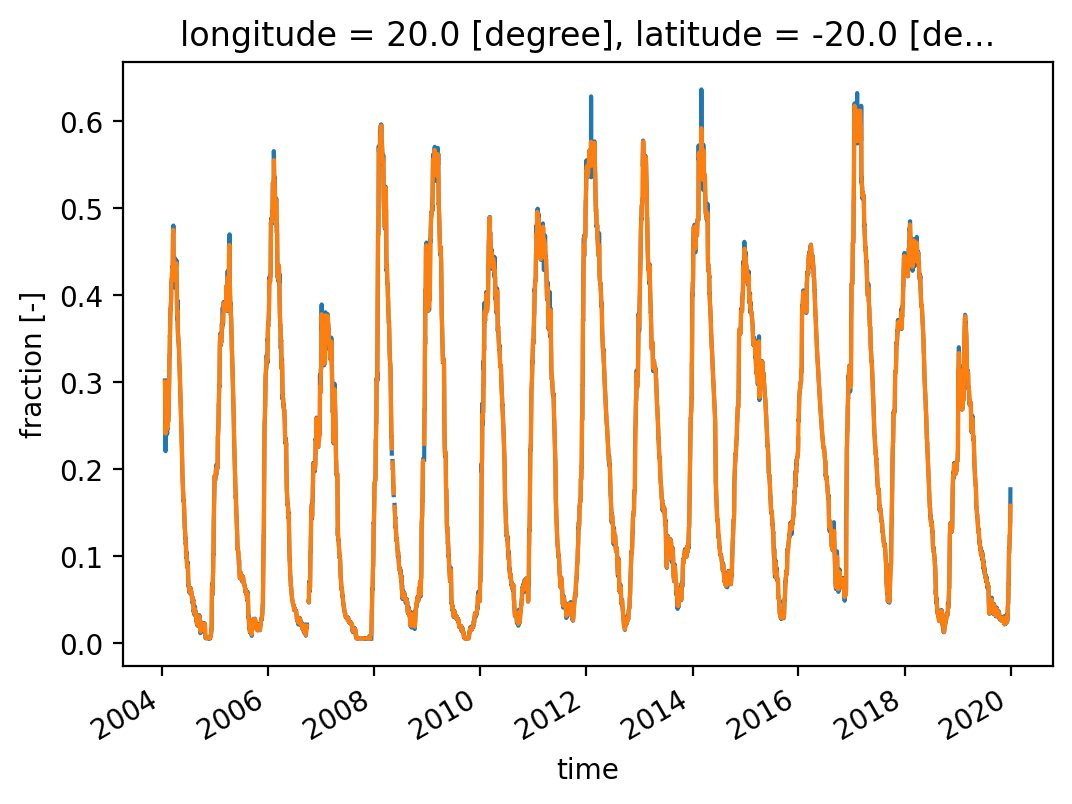

In [33]:
x.plot()
x.rolling(time=3, min_periods=2, center=True).mean().plot()

In [17]:
def get_msc(x):
    msc = x.groupby('time.dayofyear').mean()
    msc_0 = msc.copy().assign_coords(dayofyear=np.arange(1-366, 1))
    msc_1 = msc.copy().assign_coords(dayofyear=np.arange(367, 367+366))
    msc_stack = xr.concat((msc_0, msc, msc_1), dim='dayofyear')
    msc_stack = msc_stack.rolling(dayofyear=7, min_periods=4, center=True).median()
    msc_smooth = msc_stack.rolling(dayofyear=41, min_periods=21, center=True).mean().sel(dayofyear=slice(1, 366))

    return msc, msc_smooth

In [2]:
msc = xr.open_dataset('/scratch/bkraft/data/seviri/FVC.1460.1140.2004.2019_msc.nc')

In [8]:
iav = xr.open_dataset('/scratch/bkraft/data/seviri/FVC.1460.1140.2004.2019_iav.nc')

In [3]:
msc

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    FVC        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                           Climate Data Interface version 2.0.4 (http...
    Conventions:                   CF-1.6
    title:                         Fractional Vegetation Cover product derive...
    version:                       no-version-given
    reference:                     Trigo, I. F., C. C. DaCamara, P. Viterbo, ...
    provided_by:                   FVC and MTFVC were provided by the EUMETSA...
    url:                           http://lsa-saf.eumetsat.int
    history:                       Wed Mar 16 15:18:07 2022: cdo ydaymean /sc...
    created_by:                    uweber@bgc-jena.mpg.de
    spatial_interpolation_method:  near
    CDO:                           Climate Data Operators version 2.0.4 (http...

In [20]:
msc = ds.FVC.groupby('time.dayofyear').mean()

In [4]:
msc.time

<xarray.DataArray 'time' (time: 365)>
array([cftime.DatetimeNoLeap(2019, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2019, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2019-01-01 00:00:00 ... 2019-12-31 00:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

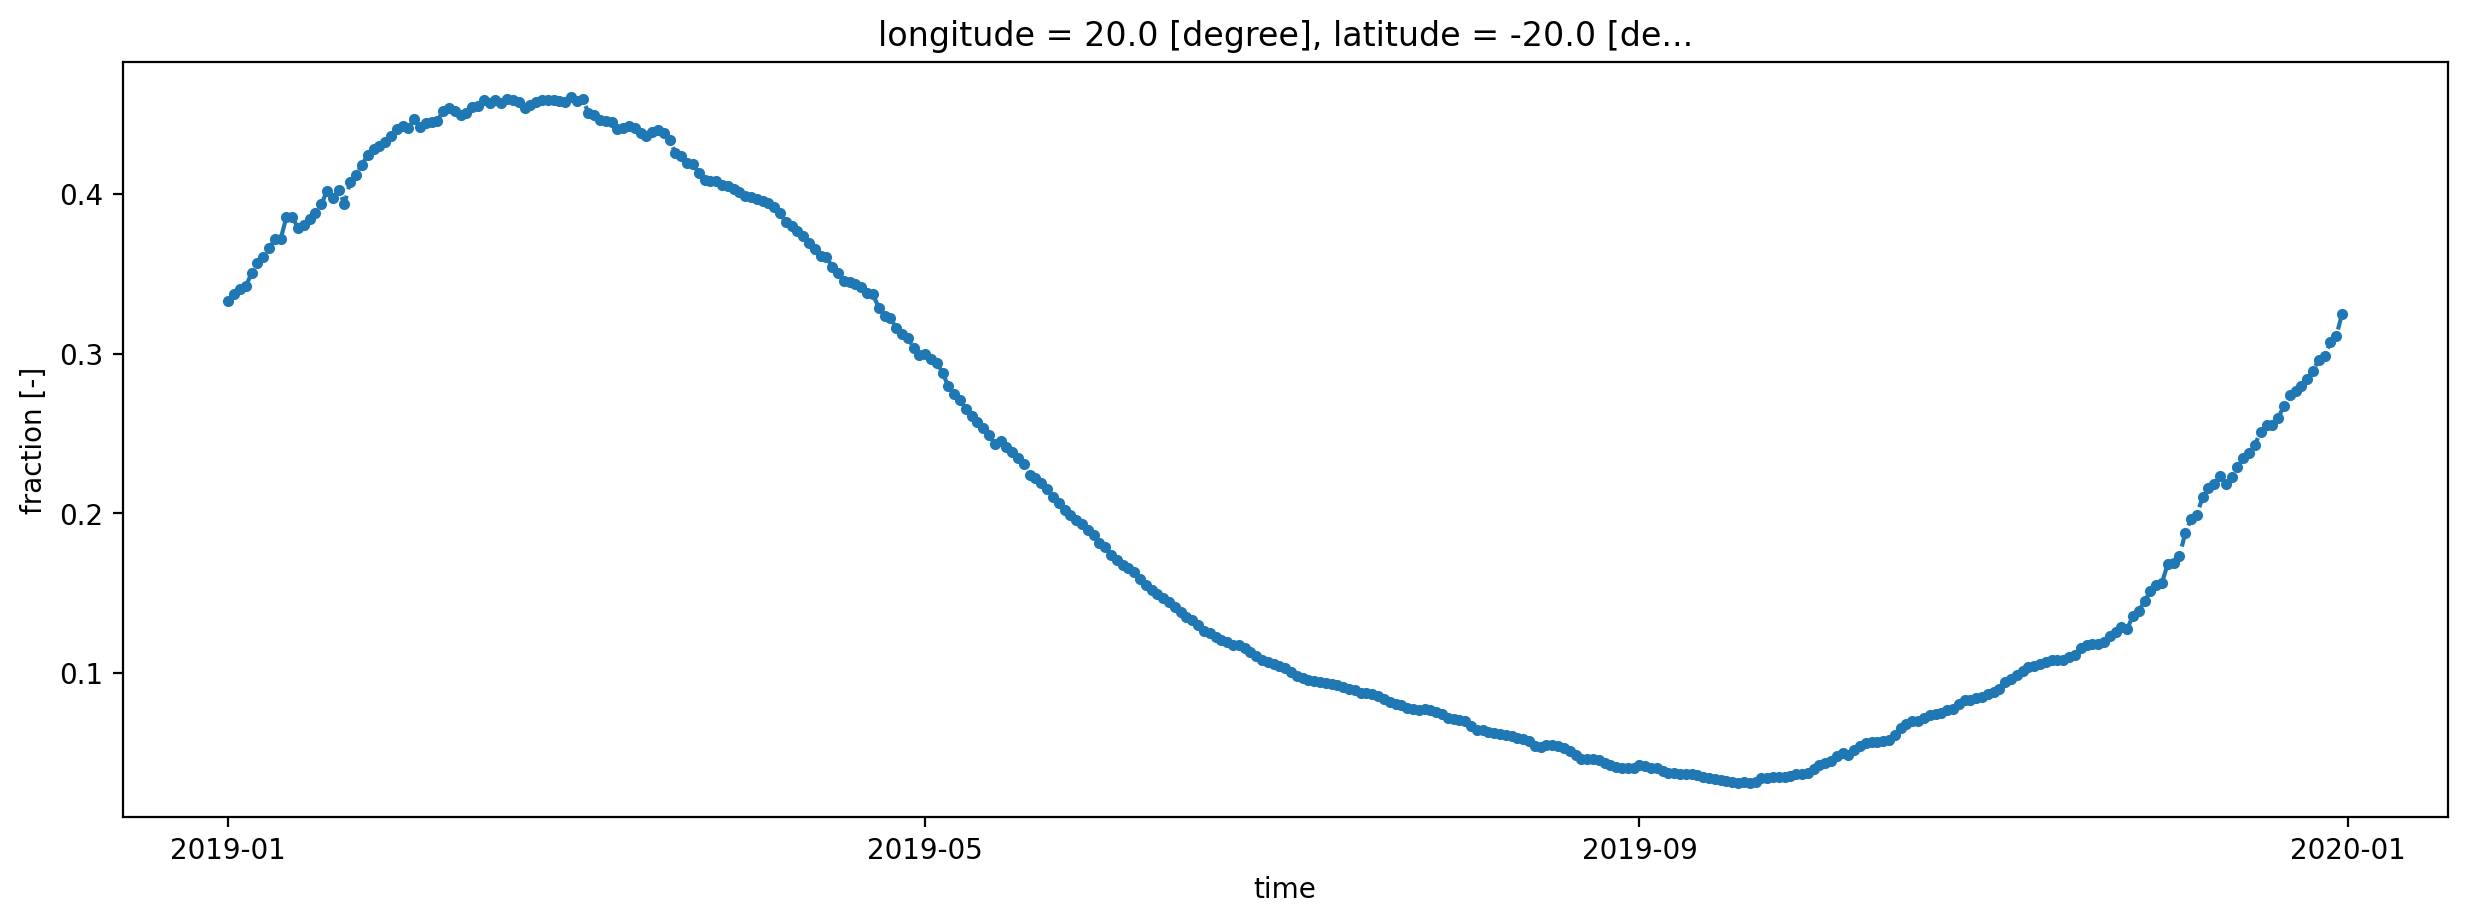

In [3]:
msc.FVC.sel(latitude=-20, longitude=20, method='nearest').plot.line('.--', figsize=(15, 5))

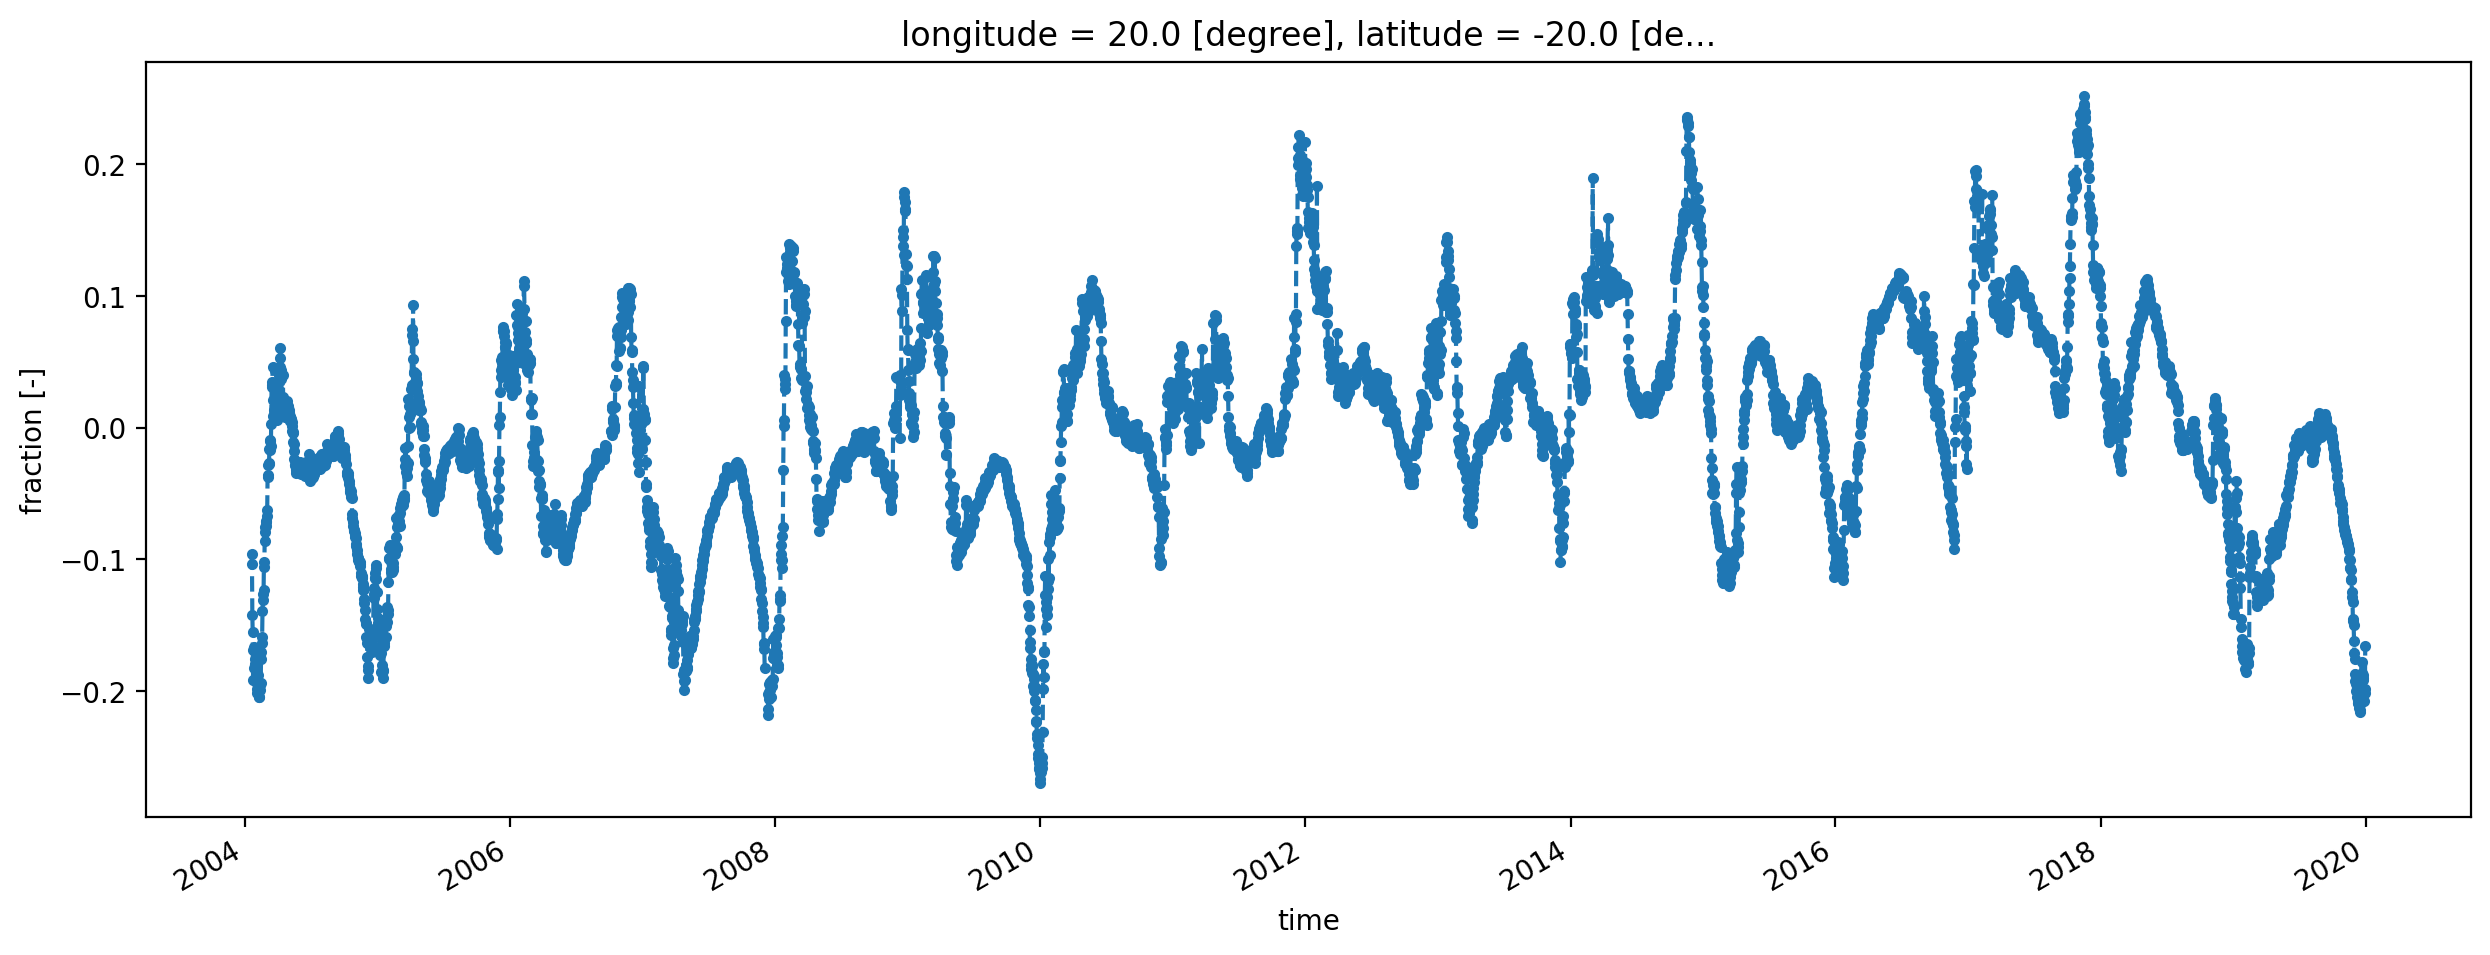

In [ ]:
iav.FVC.sel(latitude=-20, longitude=20, method='nearest').plot.line('.--', figsize=(15, 5))

In [37]:
iav

<xarray.Dataset>
Dimensions:    (time: 5844, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2019-12-31
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    FVC        (time, latitude, longitude) float32 ...
Attributes:
    CDI:                           Climate Data Interface version 2.0.4 (http...
    Conventions:                   CF-1.6
    title:                         Fractional Vegetation Cover product derive...
    version:                       no-version-given
    reference:                     Trigo, I. F., C. C. DaCamara, P. Viterbo, ...
    provided_by:                   FVC and MTFVC were provided by the EUMETSA...
    url:                           http://lsa-saf.eumetsat.int
    history:                       Wed Mar 16 15:33:47 2022: cdo sub /scratch...
    created_by:                    uweber@bgc-jena.mpg.de
    spatial_interpolation_method:  near
    CDO:                           Climate Data Operators version 2.0.4 (http...

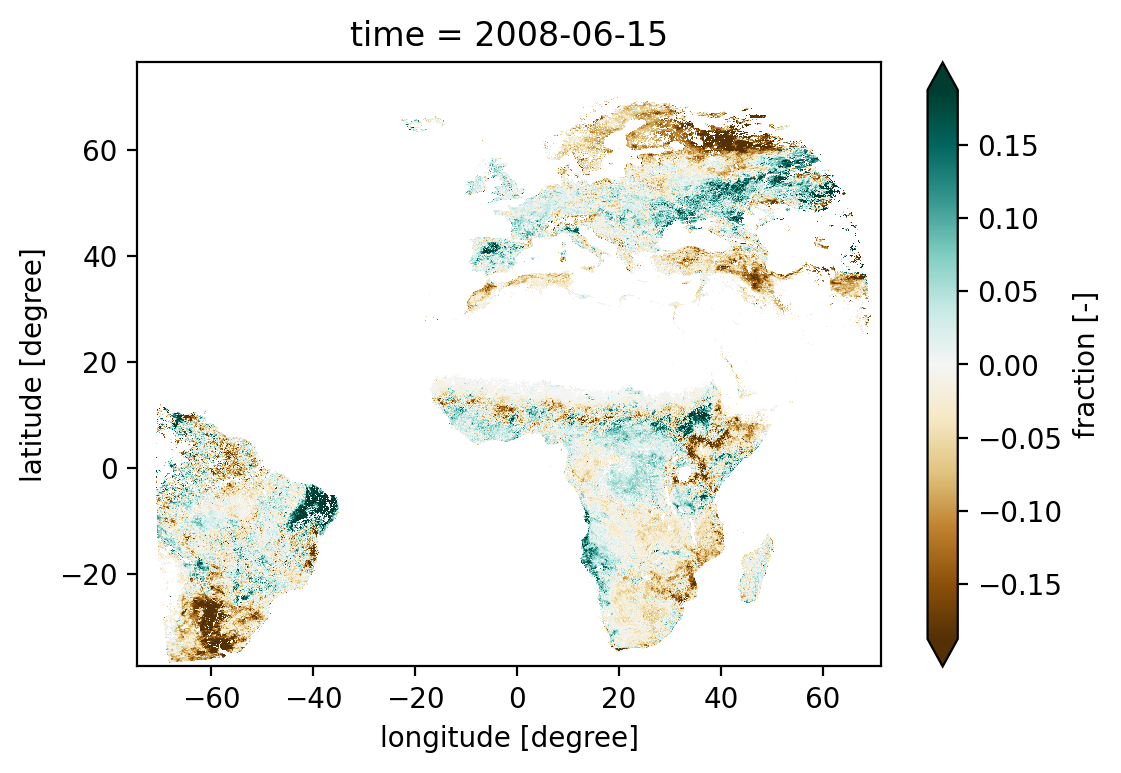

In [15]:
iav.FVC.sel(time='2008-06-15').plot(robust=True, cmap='BrBG')

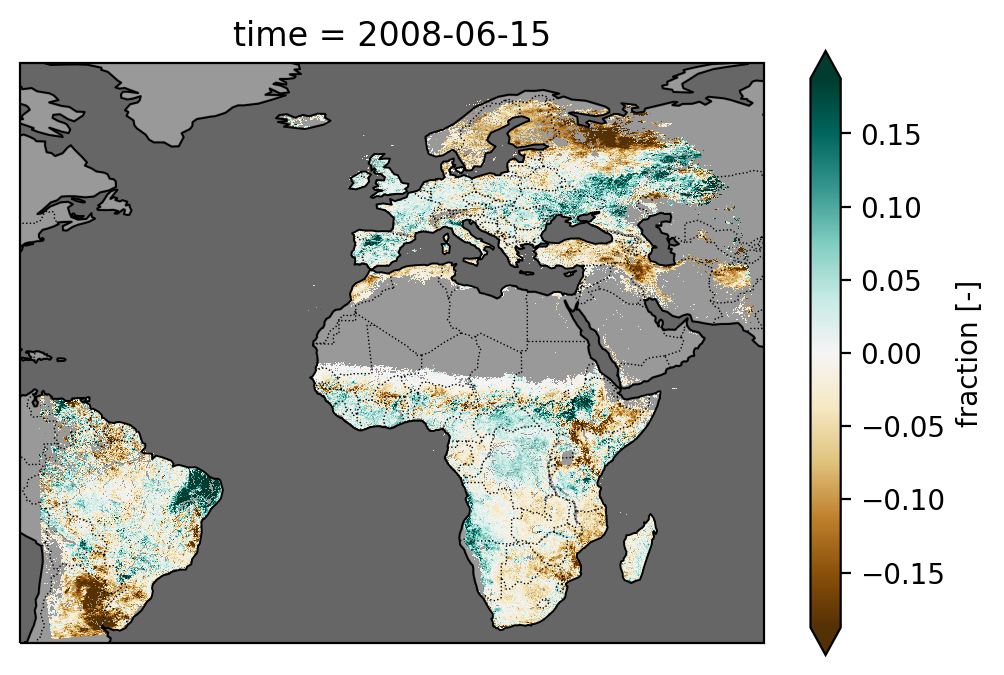

In [34]:
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_global()
iav.FVC.sel(time='2008-06-15').plot.imshow(ax=ax, cmap='BrBG', transform=ccrs.PlateCarree(), interpolation='none', robust=True)
ax.add_feature(cfeat.LAND, color='0.6')
ax.add_feature(cfeat.OCEAN, color='0.4')
ax.add_feature(cfeat.COASTLINE, lw=.7)
ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.5)

In [9]:
animate(
    iav.FVC.sel(time='2018'), vmin='-0.2', vmax='0.2', title='FVC IAV',
    cmap='BrBG',
    save_path='./anim/fvc_iav', timerange=-1, rotate_speed=0,# 360 / (365 * 2),
    ncpus=20, dpi=200, fps=15, use_pil=True)

2022-03-16 16:11:34 - Parallel execution of function `plot_t` using 20 CPUs with 365 total runs.
2022-03-16 16:12:14 - Done, elapsed time: 0 m 39 s (0 m 0 s per call).
ffmpeg -y -threads 8 -framerate 15 -pattern_type glob -i './anim/tmpq8igg5hl/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ./anim/fvc_iav.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [2]:
old = xr.open_dataset('/Net/Groups/data_BGC/era5_land/e1/0d10_hourly/tp/2018/tp.hh.fc.era5_land.01.2018.nc')

In [3]:
new = xr.open_dataset('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.nc')

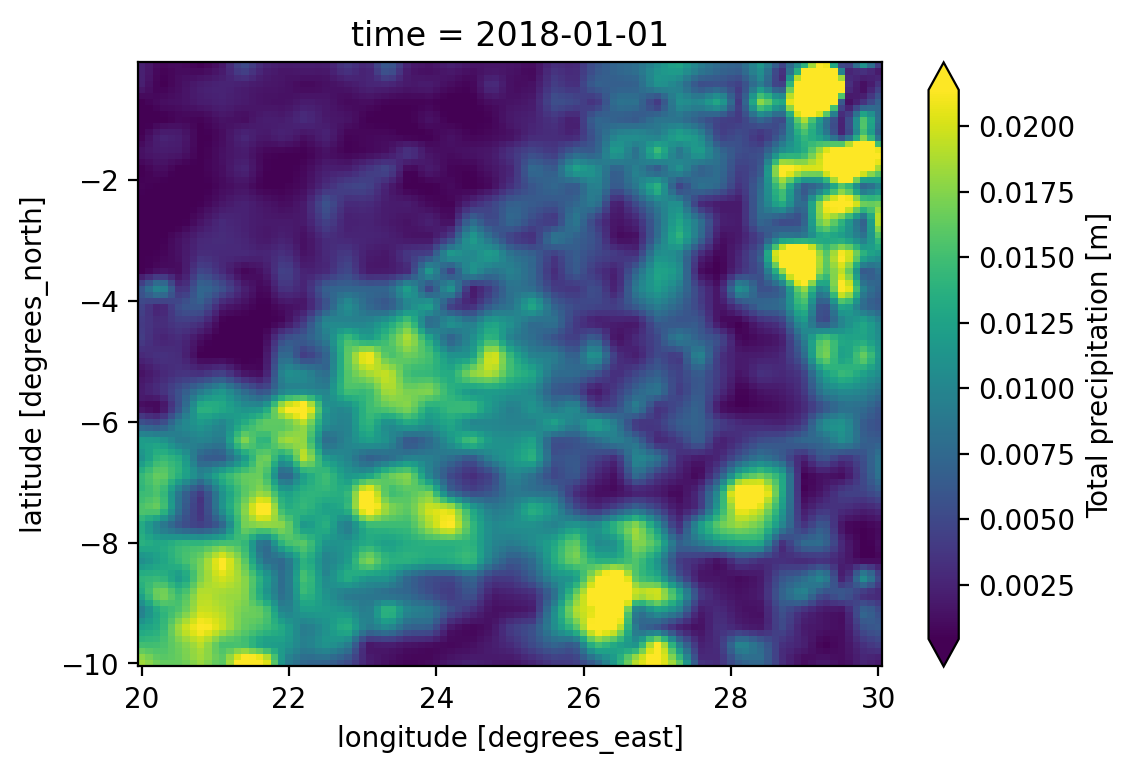

In [4]:
old.tp.isel(time=0).sel(longitude=slice(20, 30), latitude=slice(0, -10)).plot(robust=True)

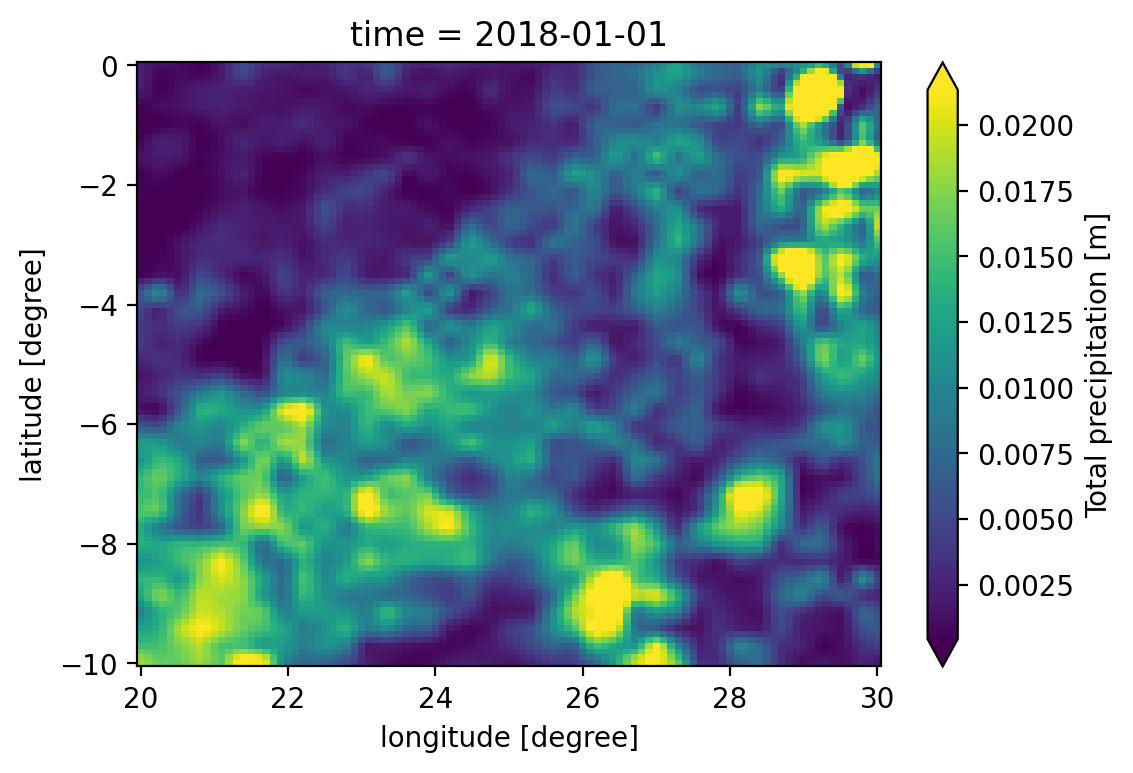

In [5]:
new.tp.isel(time=0).sel(longitude=slice(20, 30), latitude=slice(0, -10)).plot(robust=True)

In [8]:
ds = xr.open_dataset('/scratch/bkraft/data/era5_land/t2m.1460.1140.2018.nc')
ds

<xarray.Dataset>
Dimensions:    (time: 3540, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-05-28T11:00:00
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 10:05:47 2022: cdo mergetime /scratch/bkraft/dat...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [13]:
new

<xarray.Dataset>
Dimensions:    (time: 8760, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 09:19:27 2022: cdo mergetime /scratch/bkraft/dat...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

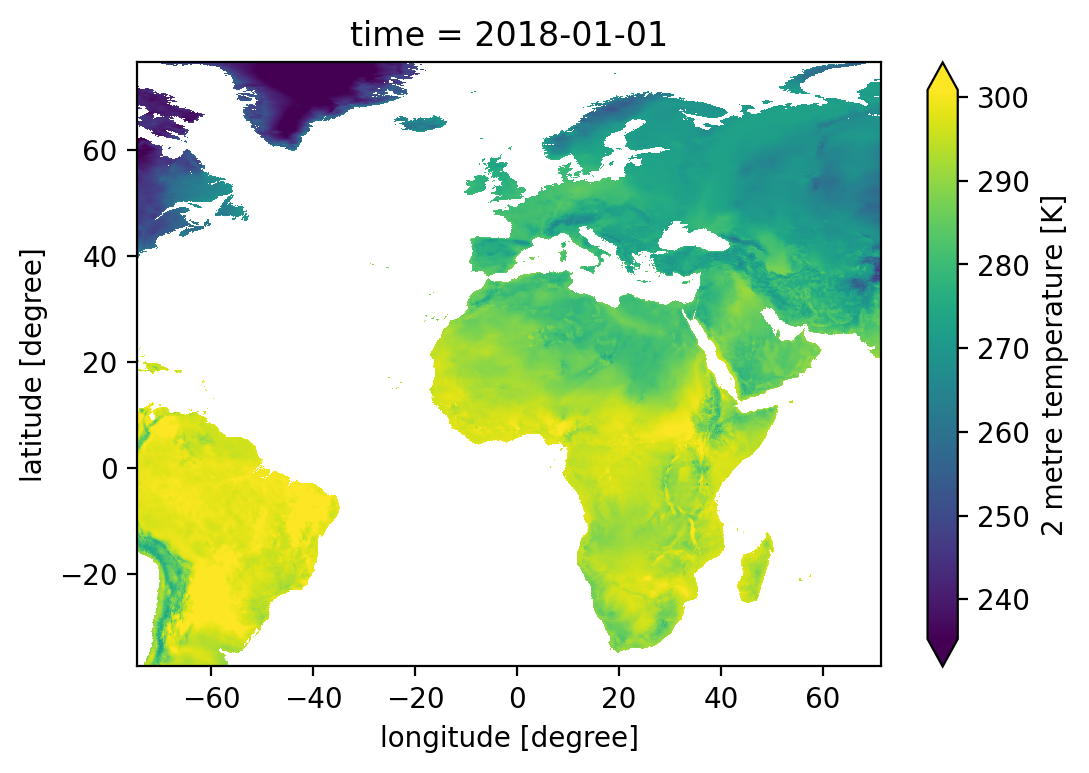

In [10]:
ds.t2m.isel(time=0).plot(robust=True)

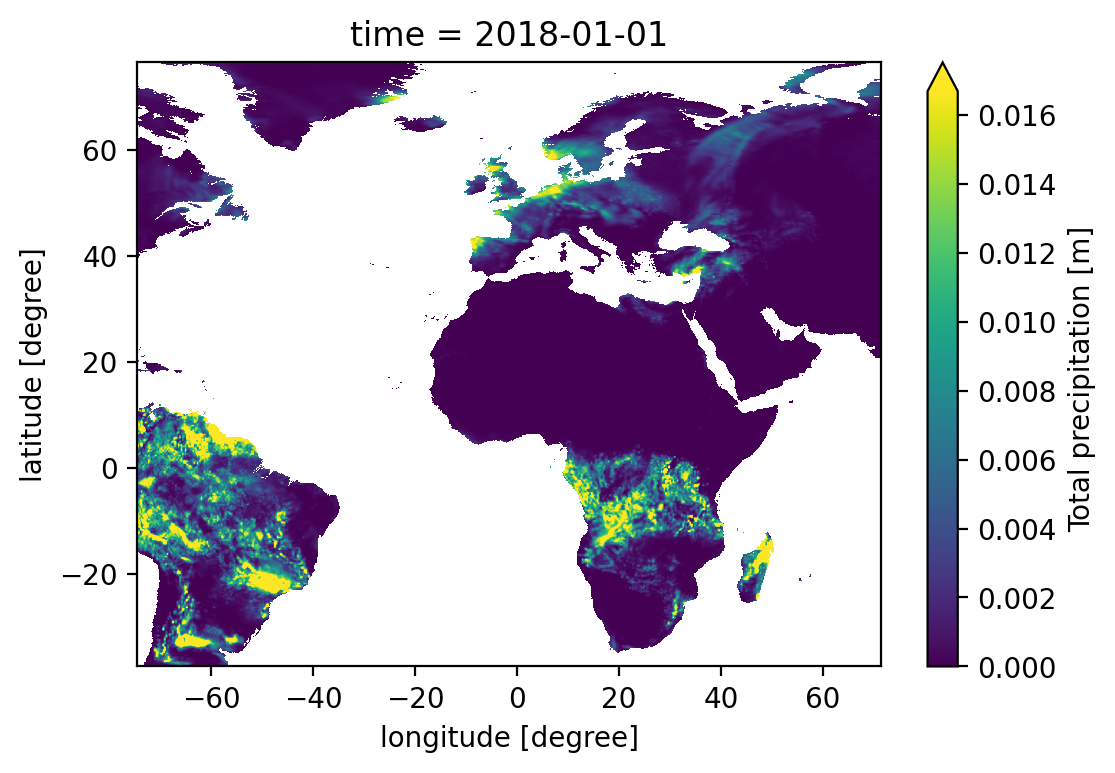

In [11]:
new.tp.isel(time=0).plot(robust=True)

In [2]:
xr.open_dataset('/scratch/bkraft/data/era5_land/t2m.1460.1140.2018.nc').time

<xarray.DataArray 'time' (time: 3540)>
array(['2018-01-01T00:00:00.000000000', '2018-01-01T01:00:00.000000000',
       '2018-01-01T02:00:00.000000000', ..., '2018-05-28T09:00:00.000000000',
       '2018-05-28T10:00:00.000000000', '2018-05-28T11:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-05-28T11:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

In [10]:
t = xr.open_dataset('/scratch/bkraft/data/era5_land/t2m.hh.an.era5_land.06.2018.nc')
t

<xarray.Dataset>
Dimensions:    (time: 720, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-06-01 ... 2018-06-30T23:00:00
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 10:33:40 2022: cdo remap,preprocessing/griddes1d...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

(array([ 114620.,  366079.,  611988., 1379779., 1893347., 3050162.,
        4933512., 3356768., 1340538.,  200759.]),
 array([249.53766, 256.7135 , 263.88934, 271.0652 , 278.24103, 285.41687,
        292.5927 , 299.76855, 306.9444 , 314.12024, 321.29608],
       dtype=float32),
 <BarContainer object of 10 artists>)

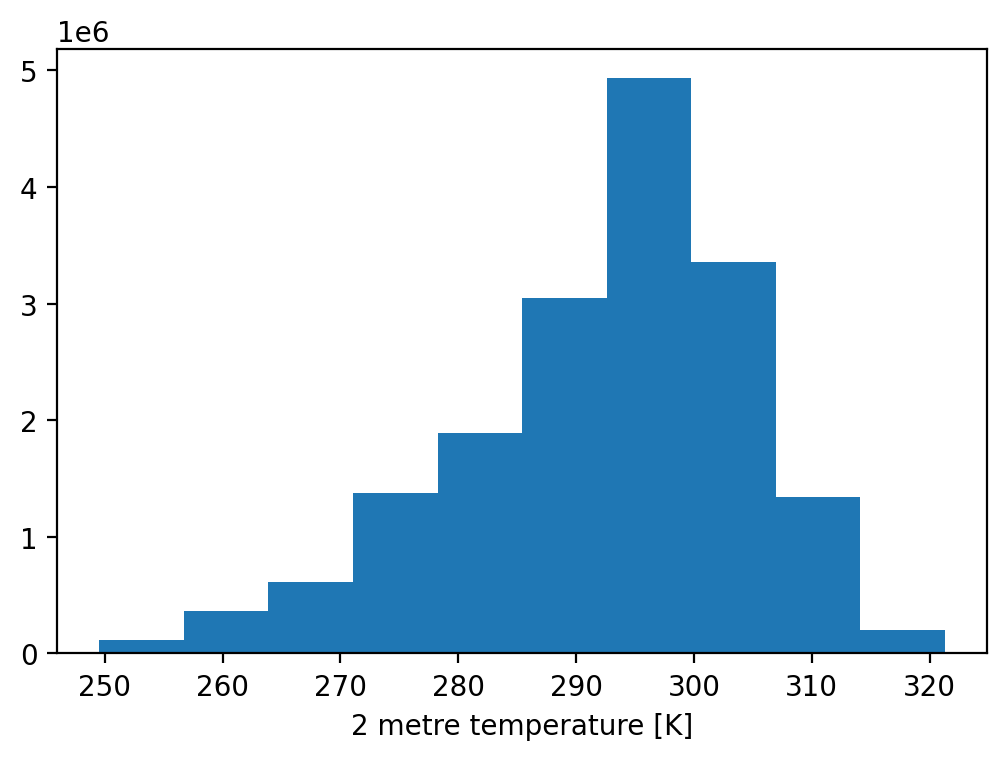

In [12]:
t.t2m.sel(time='2018-06-01').plot.hist()

In [ ]:
t.t2m.sel(time='2018-05-28T11').plot()

(array([  157.,   883.,  2785.,  5650., 11609., 19922., 28594., 29550.,
        19428.,  5766.]),
 array([258.34497, 259.98282, 261.6207 , 263.25854, 264.8964 , 266.53424,
        268.17212, 269.80997, 271.4478 , 273.0857 , 274.72354],
       dtype=float32),
 <BarContainer object of 10 artists>)

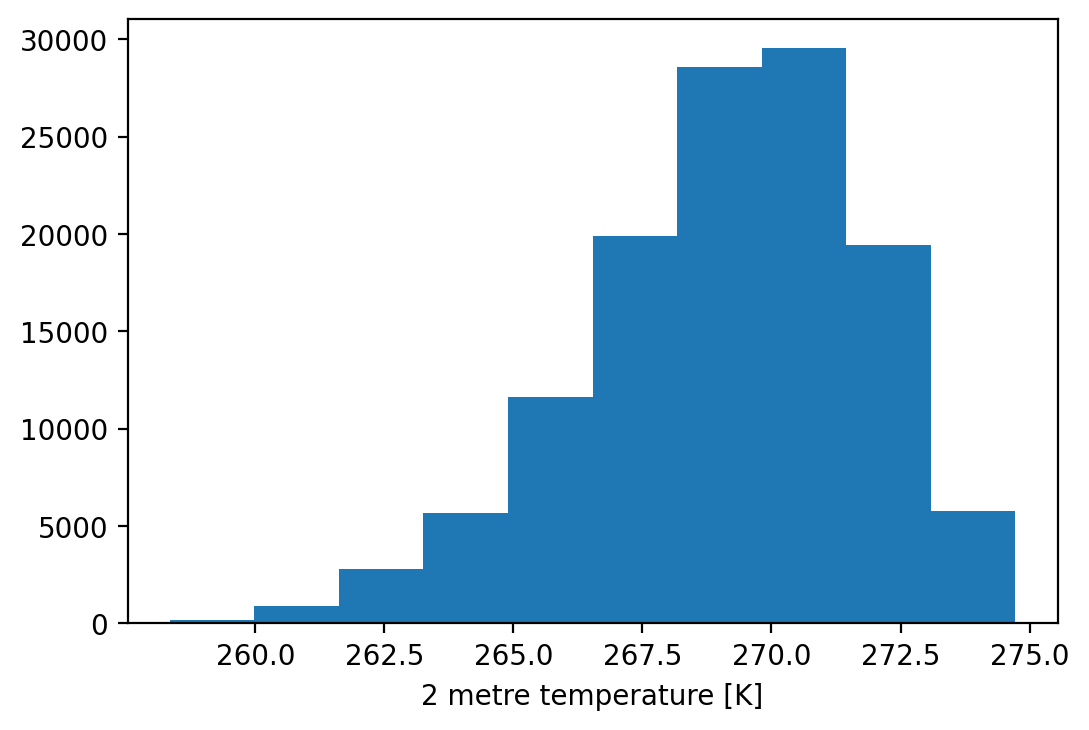

In [26]:
t.t2m.sel(time='2018-05-30').plot.hist()

In [14]:
f = xr.open_dataset('/scratch/bkraft/data/era5_land/t2m.hh.an.era5_land.06.2018.nc')
f

<xarray.Dataset>
Dimensions:    (time: 720, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-06-01 ... 2018-06-30T23:00:00
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 10:33:40 2022: cdo remap,preprocessing/griddes1d...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [16]:
f.min()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float32 237.5

In [15]:
import xarray as xr
import numpy as np

In [5]:
tair = xr.open_dataset('/scratch/bkraft/data/era5_land/t2m.1460.1140.2018.nc').sel(latitude=slice(20, 10), longitude=slice(10, 20))

In [16]:
tair1 = tair.sel(time='2018-01')
#tair1.t2m.values[:, :10, :10] = np.nan

tair2 = tair.sel(time='2018-02')

In [17]:
def compute_scale_and_offset(x):
    data_min = x.min().item()
    data_max = x.max().item()

    # stretch/compress data to the available packed range
    scale_factor = (data_max - data_min) / 46000
    # translate the range to be symmetric about zero
    add_offset = data_min + 23000 * scale_factor
    return (scale_factor, add_offset)

In [18]:
x = np.arange(2, 12)
scale_factor, add_offset = compute_scale_and_offset(x)

In [20]:
(x - add_offset) / scale_factor

array([-23000.        , -17888.88888889, -12777.77777778,  -7666.66666667,
        -2555.55555556,   2555.55555556,   7666.66666667,  12777.77777778,
        17888.88888889,  23000.        ])

In [43]:
import zarr

compressor = zarr.Blosc(cname="zlib", clevel=2, shuffle=1)
#compressor = None

encoging = {
    't2m': {
        '_FillValue': -32767, 'compressor': compressor, 'dtype': 'int16', 'chunks': (-1, 10, 10), 'scale_factor': scale_factor, 'add_offset': add_offset
    }
}

tair1.to_zarr('/scratch/bkraft/data/era5_land/temp2.zarr', mode='w')
tair1.to_zarr('/scratch/bkraft/data/era5_land/temp.zarr', mode='w', encoding=encoging)


In [44]:
t1 = xr.open_zarr('/scratch/bkraft/data/era5_land/temp.zarr', mask_and_scale=False)
t2 = xr.open_zarr('/scratch/bkraft/data/era5_land/temp2.zarr', mask_and_scale=False)

In [46]:
t1.t2m.encoding

{'chunks': (744, 10, 10),
 'preferred_chunks': {'time': 744, 'latitude': 10, 'longitude': 10},
 'compressor': Blosc(cname='zlib', clevel=2, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'dtype': dtype('int16')}

In [47]:
t2.t2m.encoding

{'chunks': (186, 26, 51),
 'preferred_chunks': {'time': 186, 'latitude': 26, 'longitude': 51},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'dtype': dtype('int16')}

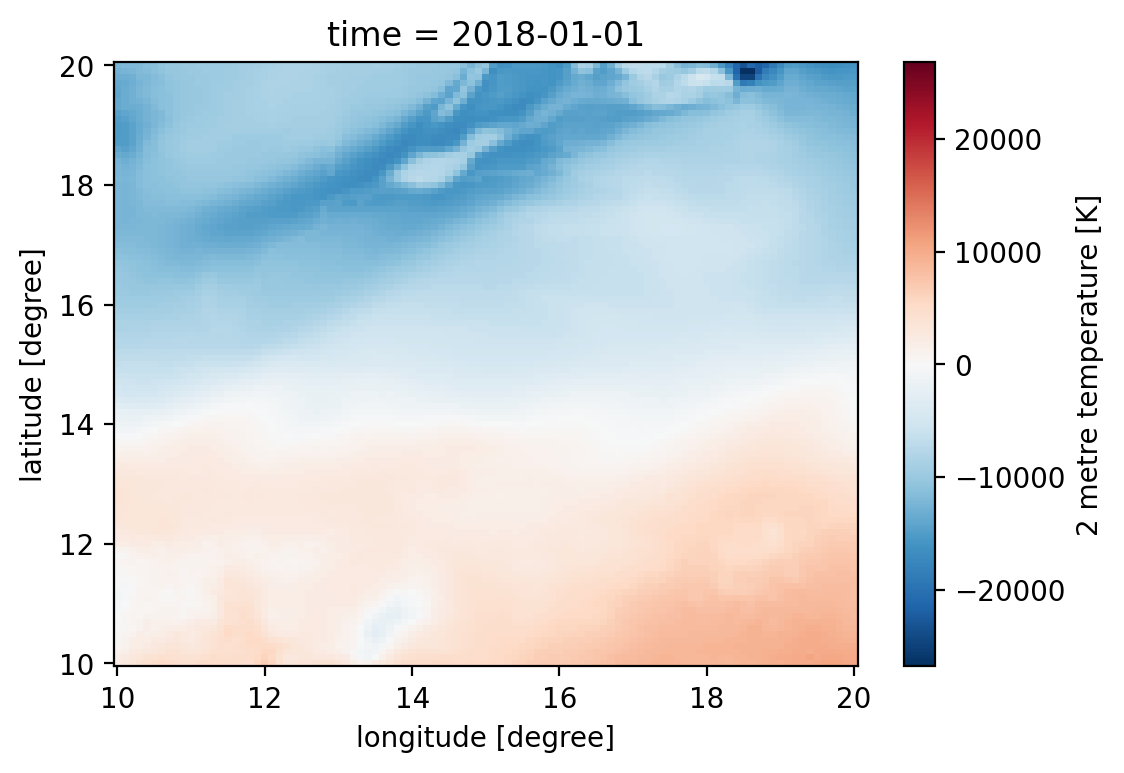

In [38]:
t1.t2m.isel(time=0).plot()

1

In [18]:
t1 = xr.open_dataset('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.nc')
t2 = xr.open_dataset('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.nc', chunks={'time': 1095, 'latitude': 570, 'longitude': 730})
t3 = xr.open_dataset('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.nc', chunks={'time': 1095, 'latitude': -1, 'longitude': -1})

In [15]:
t1

<xarray.Dataset>
Dimensions:    (time: 8760, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 14:09:15 2022: cdo -O pack -mergetime /scratch/b...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [4]:
%%time

t1.max().compute()

CPU times: user 1min 29s, sys: 1min 6s, total: 2min 36s
Wall time: 2min 36s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float32 0.4

In [7]:
%%time

t2.max().compute()

CPU times: user 1min 35s, sys: 1min 18s, total: 2min 53s
Wall time: 1min 40s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float32 0.4

In [17]:
%%time

t2.max().compute()

CPU times: user 1min 35s, sys: 1min 6s, total: 2min 41s
Wall time: 35.7 s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float32 0.4

In [19]:
%%time

t3.max().compute()

CPU times: user 1min 42s, sys: 1min 14s, total: 2min 56s
Wall time: 40.1 s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float32 0.4

In [60]:
a = 1140
b = 1460

n = 10

print(a, a/n, b, b/n)

1140 114.0 1460 146.0


In [61]:
t = xr.open_dataset('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.nc', chunks={'time': -1, 'latitude': 10, 'longitude': 10})
t.to_zarr('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.zarr',
              mode='w', encoding={'tp': {'chunks': (-1, 10, 10)}})


In [ ]:
t = xr.open_dataset('/scratch/bkraft/data/era5_land/tp.1460.1140.2019.nc', chunks={'time': -1, 'latitude': 10, 'longitude': 10})
t.to_zarr('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.zarr',
              mode='a', append_dim='time')

In [55]:
xr.open_zarr('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.zarr')

<xarray.Dataset>
Dimensions:    (latitude: 1140, longitude: 1460, time: 8760)
Coordinates:
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(1095, 570, 730), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 14:09:15 2022: cdo -O pack -mergetime /scratch/b...

In [21]:

import xarray as xr
from glob import glob

CHUNKS = {'time': -1, 'latitude': 10, 'longitude': 10}

def run():
    years = [2018, 2019]
    era_vars = ['tp']
    seviri_vars = ['FVC']

    for var in era_vars:
        files = glob(f'/scratch/bkraft/data/era5_land/{var}.1460.1140.*.nc')
        data_stack = xr.open_mfdataset(
            files, parallel=True, chunks=CHUNKS).rename({'latitude': 'lat', 'longitude': 'lon'})

        data_stack.to_zarr(
            f'/scratch/bkraft/data/era5_land/{var}.1460.1140.{years[0]}.{years[-1]}.zarr',
            mode='w', encoding={'tp': {'chunks': tuple(CHUNKS.values())}})


In [6]:
%%time

run()

UsageError: Cell magic `%%` not found.


In [22]:
import xarray as xr
from datetime import datetime

In [23]:
def readf(path):
    d = xr.open_zarr(path)
    start = datetime.now()
    d.isel(time=40).compute()
    e1 = datetime.now()
    d.sel(lon=100, lat=100, method='nearest').compute()
    e2 = datetime.now()
    print(path)
    print('read time slice: ', e1 - start)
    print('read time series: ', e2 - e1)

In [24]:
readf('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.-1.latitude.73.longitude.73.zarr/')

/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.-1.latitude.73.longitude.73.zarr/
read time slice:  0:00:12.578366
read time series:  0:00:00.614399


In [25]:
readf('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.2000.latitude.10.longitude.10.zarr/')

/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.2000.latitude.10.longitude.10.zarr/
read time slice:  0:00:20.496662
read time series:  0:00:00.141750


In [26]:
readf('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.2000.latitude.73.longitude.73.zarr/')

/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.2000.latitude.73.longitude.73.zarr/
read time slice:  0:00:03.117069
read time series:  0:00:00.155684


In [27]:
readf('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.1000.latitude.73.longitude.73.zarr/')

/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.1000.latitude.73.longitude.73.zarr/
read time slice:  0:00:01.730963
read time series:  0:00:00.152027


In [28]:
readf('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.500.latitude.73.longitude.73.zarr/')

/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.500.latitude.73.longitude.73.zarr/
read time slice:  0:00:01.045516
read time series:  0:00:00.132710


In [29]:
readf('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.200.latitude.73.longitude.73.zarr/')

/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.200.latitude.73.longitude.73.zarr/
read time slice:  0:00:00.540490
read time series:  0:00:00.171827


In [31]:
readf('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.500.latitude.73.longitude.73.zarr/')

/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.500.latitude.73.longitude.73.zarr/
read time slice:  0:00:01.310039
read time series:  0:00:00.162096


In [37]:
d = xr.open_zarr('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.500.latitude.73.longitude.73.zarr/')
d

ValueError: conflicting sizes for dimension 'time': length 8760 on 'tp' and length 17520 on {'lat': 'lat', 'lon': 'lon', 'time': 't2m'}

In [33]:
d.t2m.isel(time=10).plot(robust=True)

<xarray.Dataset>
Dimensions:  (lat: 1140, lon: 1460, time: 8760)
Coordinates:
  * lat      (lat) float64 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float64 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(500, 73, 73), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 14:09:15 2022: cdo -O pack -mergetime /scratch/b...

In [66]:
d = xr.open_zarr('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.500.latitude.73.longitude.73.zarr/')
d.tp.encoding

/raid/scratch/tmp/ipykernel_60097/3358840282.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  d = xr.open_zarr('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.2000.latitude.10.longitude.10.zarr/')


GroupNotFoundError: group not found at path ''

In [14]:
d

<xarray.Dataset>
Dimensions:  (lat: 1140, lon: 1460, time: 17520)
Coordinates:
  * lat      (lat) float64 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float64 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2019-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(2000, 10, 10), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 14:34:03 2022: cdo -O pack -mergetime /scratch/b...

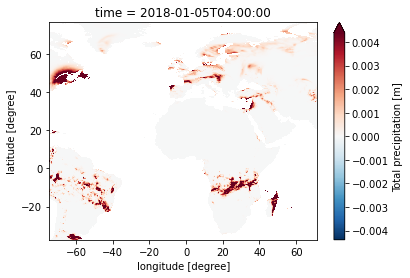

In [25]:
d.isel(time=100).tp.plot(robust=True)

In [31]:
d.tp.encoding

{'chunks': (8760, 10, 10),
 'preferred_chunks': {'time': 8760, 'lat': 10, 'lon': 10},
 'compressor': Blosc(cname='zlib', clevel=2, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': -32767,
 'scale_factor': 8.694637080897456e-06,
 'add_offset': 0.1999766528606415,
 'dtype': dtype('int16')}

In [5]:
d.tp.isel(time=0).plot()

ModuleNotFoundError: No module named 'matplotlib'

In [39]:
d

<xarray.Dataset>
Dimensions:  (lat: 1140, lon: 1460, time: 8760)
Coordinates:
  * lat      (lat) float64 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
  * lon      (lon) float64 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(500, 73, 73), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 14:09:15 2022: cdo -O pack -mergetime /scratch/b...

In [2]:
import sys
sys.path.append('../')

In [3]:
from preprocessing.harmonize import run_new

In [4]:
run(write_chunks={'time': 2000, 'latitude': 10, 'longitude': 10})

>>> 2022-03-21 16:32:18 Processing 1 variable(s) with 2 year(s) each.
>>> 2022-03-21 16:32:18 Processing vaiable `tp` (2018).
>>> 2022-03-21 16:32:18   - calculate scale factors
>>> 2022-03-21 16:33:34   - write data
>>> 2022-03-21 16:34:40 Processing vaiable `tp` (2019).
>>> 2022-03-21 16:34:40   - append data
>>> 2022-03-21 16:36:03 Done (3m 4e+01s)


In [3]:
run(write_chunks={'time': 2000, 'latitude': 73, 'longitude': 73})

>>> 2022-03-21 16:27:00 Processing 1 variable(s) with 2 year(s) each.
>>> 2022-03-21 16:27:00 Processing vaiable `tp` (2018).
>>> 2022-03-21 16:27:00   - calculate scale factors
>>> 2022-03-21 16:28:15   - write data
>>> 2022-03-21 16:29:21 Processing vaiable `tp` (2019).
>>> 2022-03-21 16:29:21   - append data
>>> 2022-03-21 16:30:37 Done (3m 4e+01s)


In [ ]:
run(write_chunks={'time': -1, 'latitude': 73, 'longitude': 73})

>>> 2022-03-21 16:37:28 Processing 1 variable(s) with 2 year(s) each.
>>> 2022-03-21 16:37:28 Processing vaiable `tp` (2018).
>>> 2022-03-21 16:37:28   - calculate scale factors
>>> 2022-03-21 16:38:44   - write data
>>> 2022-03-21 16:41:02 Processing vaiable `tp` (2019).
>>> 2022-03-21 16:41:02   - append data


In [ ]:
run(write_chunks={'time': 1000, 'latitude': 73, 'longitude': 73})

>>> 2022-03-21 16:53:17 Processing 1 variable(s) with 2 year(s) each.
>>> 2022-03-21 16:53:17 Processing vaiable `tp` (2018).
>>> 2022-03-21 16:53:17   - calculate scale factors
>>> 2022-03-21 16:54:34   - write data


In [9]:
run(write_chunks={'time': 500, 'latitude': 73, 'longitude': 73})

>>> 2022-03-21 17:02:50 Processing 1 variable(s) with 2 year(s) each.
>>> 2022-03-21 17:02:50 Processing vaiable `tp` (2018).
>>> 2022-03-21 17:02:51   - calculate scale factors
>>> 2022-03-21 17:04:12   - write data
>>> 2022-03-21 17:05:23 Processing vaiable `tp` (2019).
>>> 2022-03-21 17:05:23   - append data
>>> 2022-03-21 17:06:37 Done (3m 5e+01s)


In [4]:
run_new()

>>> 2022-03-21 18:48:41 Processing 1 variable(s) with 2 year(s) each.
>>> 2022-03-21 18:48:41   - calculate scale factors
>>> 2022-03-21 18:49:57   - write data



KeyboardInterrupt



In [5]:
for i in range(1, 366):
    if (730 % i) == 0:
        print(i)

1
2
5
10
73
146
365


In [53]:
import numpy as np
import xarray as xr
import pandas as pd
import zarr

In [211]:

time = pd.date_range('2018-01-01', '2018-02-28', freq='H')

ds0 = xr.Dataset()
ds0['x'] = xr.DataArray(np.arange(len(time)), coords=[time.values], dims=['time'])

ds1 = xr.Dataset()
ds1['y'] = xr.DataArray(np.arange(len(time)), coords=[time.values], dims=['time'])

In [212]:
ds00 = ds0.sel(time='2018-01')
ds01 = ds0.sel(time='2018-02')
ds10 = ds1.sel(time='2018-01')
ds11 = ds1.sel(time='2018-02')

In [149]:
ds00.indexes['time'].get_loc

<bound method DatetimeIndex.get_loc of DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2018-01-31 14:00:00', '2018-01-31 15:00:00',
               '2018-01-31 16:00:00', '2018-01-31 17:00:00',
               '2018-01-31 18:00:00', '2018-01-31 19:00:00',
               '2018-01-31 20:00:00', '2018-01-31 21:00:00',
               '2018-01-31 22:00:00', '2018-01-31 23:00:00'],
              dtype='datetime64[ns]', name='time', length=744, freq=None)>

In [145]:
ds00.isel(time=time.get_loc('2018-01'))

<xarray.Dataset>
Dimensions:  (time: 744)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
Data variables:
    x        (time) int64 0 1 2 3 4 5 6 7 8 ... 736 737 738 739 740 741 742 743

In [ ]:
.index.get_loc(idx)

In [58]:
ds = xr.merge([ds00, ds01, ds10, ds11])

In [59]:
compressor = zarr.Blosc(cname="zlib", clevel=2, shuffle=1)

encoding = {
    var: {
        'compressor': compressor,
        'dtype': 'int16',
    } for var in ['x', 'y']
}

xr.zeros_like(ds).to_zarr('./test.zarr', compute=True, mode='w', encoding=encoding)

/Net/Groups/BGI/people/bkraft/anaconda3/envs/preproc/lib/python3.9/site-packages/xarray/core/dataset.py:2036: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(


In [131]:
ds00.to_zarr('./test.zarr', mode='a', region={'time': slice(0, 31)})

In [132]:
ds01.to_zarr('./test.zarr', mode='a', region={'time': slice(31, 59)})

In [62]:
ds10.to_zarr('./test.zarr', mode='a', region={'time': slice(0, 31)})

In [63]:
ds11.to_zarr('./test.zarr', mode='a', region={'time': slice(31, 59)})

In [95]:
xr.open_zarr('/scratch/bkraft/data/era5_land/test.zarr')

<xarray.Dataset>
Dimensions:    (latitude: 1140, longitude: 1460, time: 8760)
Coordinates:
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 730, 730), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 13:56:12 2022: cdo -O pack -mergetime /scratch/b...

In [102]:
d = xr.open_dataset('/scratch/bkraft/data/era5_land/t2m.1460.1140.2018.nc', chunks={'time': 2000, 'latitude': 730, 'longitude': 730})
d

<xarray.Dataset>
Dimensions:    (time: 8760, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 730, 730), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 13:56:12 2022: cdo -O pack -mergetime /scratch/b...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [117]:
compressor = zarr.Blosc(cname="zlib", clevel=2, shuffle=1)

READ_CHUNKS = {'time': 2000, 'latitude': 730, 'longitude': 730}
WRITE_CHUNKS = {'time': 500, 'latitude': 73, 'longitude': 73}

encoding = {
    var: {
        'compressor': compressor,
        'chunks': tuple(WRITE_CHUNKS.values())
    } for var in ['t2m']
}

xr.zeros_like(d).to_zarr('/scratch/bkraft/data/era5_land/test.zarr', compute=False, mode='w', encoding=encoding)

Delayed('_finalize_store-d31b641c-1786-4fb9-a0f7-9f64cf4ca7d3')

In [118]:
d

<xarray.Dataset>
Dimensions:    (time: 8760, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
  * longitude  (longitude) float64 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float64 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 730, 730), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Mar 17 13:56:12 2022: cdo -O pack -mergetime /scratch/b...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [119]:
d.isel(time=slice(0, 10)).drop(['latitude', 'longitude']).to_zarr('/scratch/bkraft/data/era5_land/test.zarr', region={'time': slice(0, 10)})

In [120]:
n = xr.open_zarr('/scratch/bkraft/data/era5_land/test.zarr')

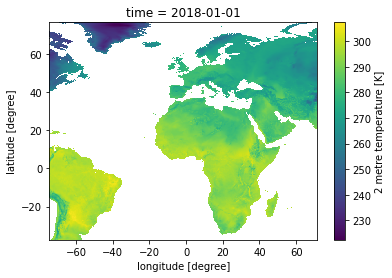

In [121]:
n.t2m.isel(time=0).plot()

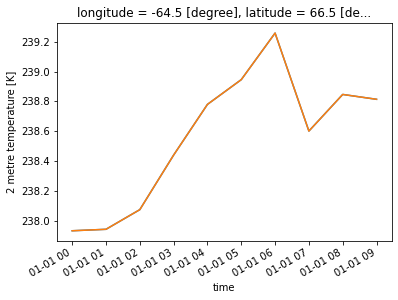

In [123]:
n.isel(latitude=100, longitude=100).t2m.plot()
d.t2m.isel(latitude=100, longitude=100, time=slice(0, 10)).plot()

In [130]:
xr.open_dataset('/scratch/bkraft/data/era5_land/tp.1460.1140.2018.nc', chunks=READ_CHUNKS).sel(latitude=slice(20, 10), longitude=slice(10, 20)).to_netcdf('/scratch/bkraft/data/era5_land/tp.1460.1140.2018_TEST.nc')

In [170]:
o = xr.open_mfdataset(['/scratch/bkraft/data/era5_land/t2m.1460.1140.2018_TEST.nc', '/scratch/bkraft/data/era5_land/t2m.1460.1140.2019_TEST.nc'])

In [171]:
n = xr.open_zarr('/scratch/bkraft/data/era5_land/era5land.1460.1140.2018.2019_time.500.latitude.73.longitude.73.zarr/')

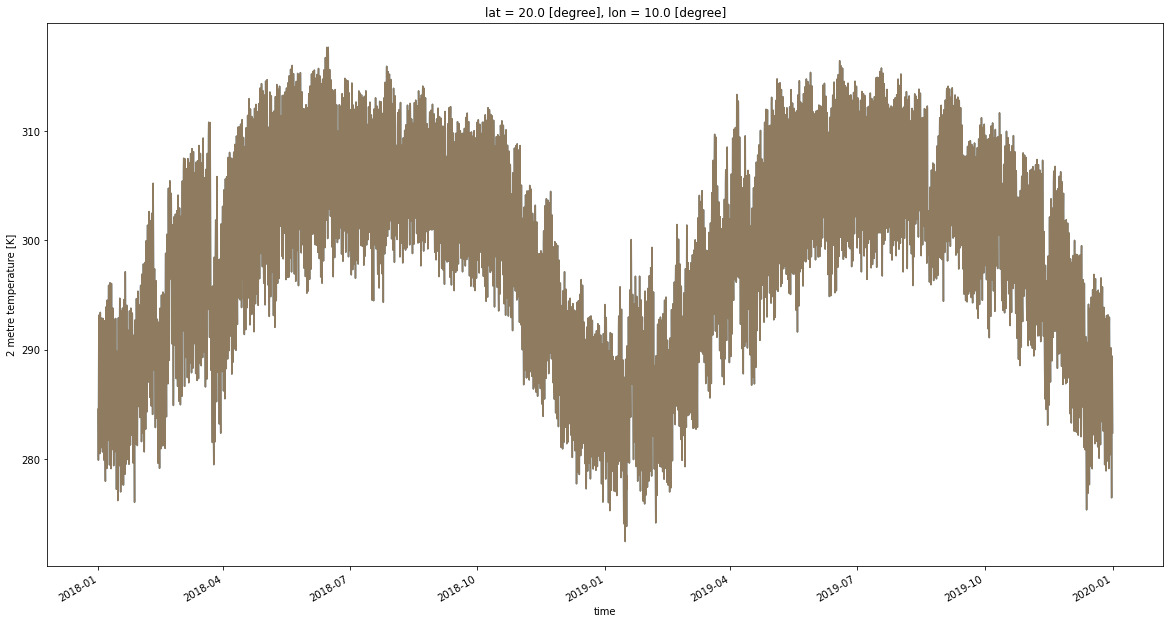

In [173]:
plt.figure(figsize=(20, 10))
o.t2m.isel(latitude=0, longitude=0).plot()
n.t2m.isel(lat=0, lon=0).plot(alpha=0.5)

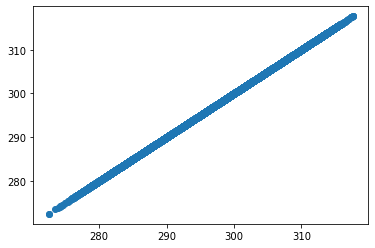

In [174]:
plt.scatter(o.t2m.isel(latitude=0, longitude=0), n.t2m.isel(lat=0, lon=0))

In [196]:
print(f'{1.3:2.0f}')

 1


In [214]:
ds00.to_zarr('./test.zarr', group='a')

In [217]:
ds00

<xarray.Dataset>
Dimensions:  (time: 744)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-01-31T23:00:00
Data variables:
    x        (time) int64 0 1 2 3 4 5 6 7 8 ... 736 737 738 739 740 741 742 743

In [216]:
ds.to_zarr('./test.zarr', group='b')

In [218]:
ds

<xarray.Dataset>
Dimensions:  (time: 59)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-02-28
Data variables:
    x        (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 54.0 55.0 56.0 57.0 58.0
    y        (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 54.0 55.0 56.0 57.0 58.0

In [11]:
ds = xr.open_dataset('/Net/Groups/BGI/people/bkraft/hydrodl_experiment_backups_202109/experiments/hybrid/all_vars_task_weighting/cv/predictions_all/pred_01_1/daily_pred.nc')
ds.gwrec_frac.max()

<xarray.DataArray 'gwrec_frac' ()>
array(0.73333585)

In [12]:
ds_sel = ds.sel(time='2004')

animate(
    [ds_sel.smrec_frac, ds_sel.gwrec_frac, ds_sel.qf_frac], vmin=[0, 0, 0], vmax=[1, 1, 1], title=['SM frac (-)', 'GW frac (-)', 'Qf frac (-)'],
    cmap=['Greens_r', 'Blues_r', 'Oranges_r'],
    save_path='./anim/fracs', timerange=-1, globe=False,
    ncpus=20, dpi=300, fps=20, use_pil=True)

2022-05-17 12:38:58 - Parallel execution of function `plot_t` using 20 CPUs with 366 total runs.


(remote_fun pid=1040) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=1049) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=1039) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=1034) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=1037) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatib

2022-05-17 12:42:41 - Done, elapsed time: 3 m 42 s (0 m 0 s per call).
ffmpeg -y -threads 16 -framerate 20 -pattern_type glob -i './anim/tmp6tksv481/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ./anim/fracs.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


In [23]:
ds_sel = ds.sel(time='2004')

animate(
    [ds_sel.cwd - ds_sel.cwd.min('time'), ds_sel.gw, ds_sel.swe], vmin=[0, 0, 0], vmax=["300", "100", "100"], title=['SM (mm)', 'GW (mm)', 'SWE (mm)'],
    cmap=['RdPu_r', 'OrRd_r', 'GnBu_r'],
    save_path='./anim/storages', timerange=-1, globe=False,
    ncpus=20, dpi=300, fps=20, use_pil=True)

2022-05-17 13:53:04 - Parallel execution of function `plot_t` using 20 CPUs with 366 total runs.


(remote_fun pid=23261) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=23267) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=23262) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=23253) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=23257) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incom

2022-05-17 13:56:53 - Done, elapsed time: 3 m 48 s (0 m 0 s per call).
ffmpeg -y -threads 16 -framerate 20 -pattern_type glob -i './anim/tmp3br5j9ba/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ./anim/storages.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


frame=  366 fps=0.8 q=0.0 Lsize=    3707kB time=00:00:18.25 bitrate=1663.9kbits/s speed=0.0381x    
video:2724kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 36.112198%


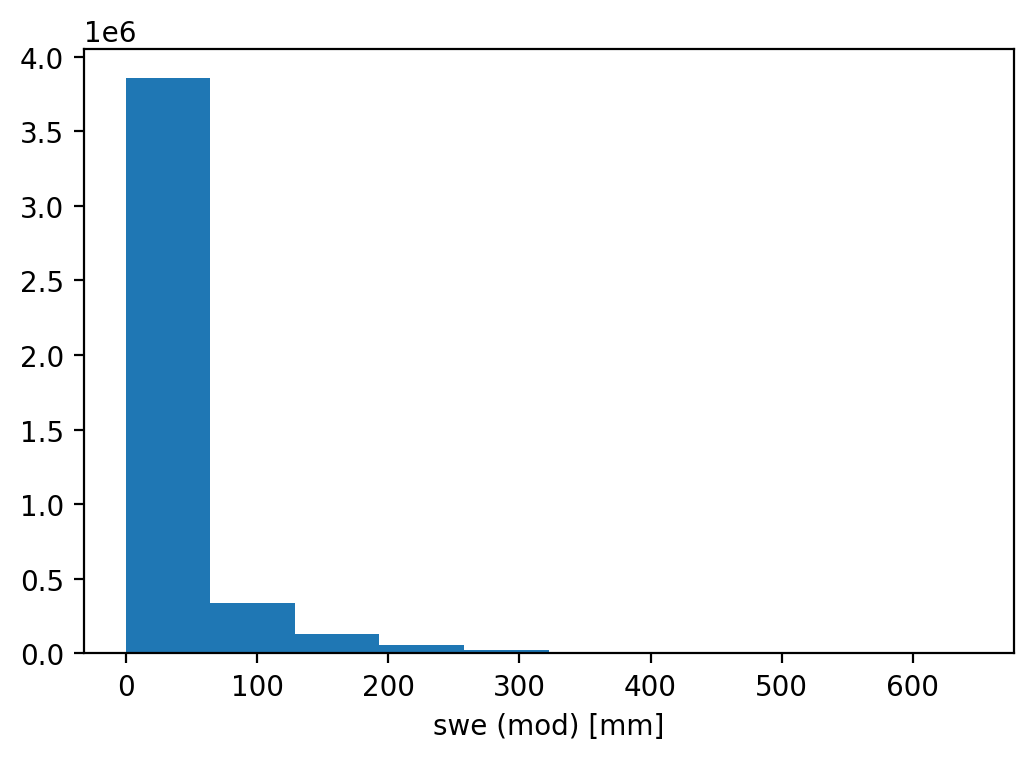

In [17]:
ds_sel.swe.plot.hist();

In [6]:
animate(
    [ds.smrec.sel(time=slice('2004', '2005')), -(ds.cwd - ds.cwd.mean('time')).sel(time=slice('2004', '2005'))], vmin=[0, '-200'], vmax=['30', '200'], title=['SM recharge (mm d-1)', 'SM anomalies (mm)'],
    cmap=['Blues_r', 'BrBG'],
    save_path='./anim/h2m/', timerange=-1, globe=False,
    ncpus=20, dpi=300, fps=20, use_pil=True)

2022-03-31 10:46:55 - Parallel execution of function `plot_t` using 20 CPUs with 731 total runs.


(remote_fun pid=6183) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6176) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6198) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6200) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
(remote_fun pid=6175) <frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatib

2022-03-31 10:49:50 - Done, elapsed time: 2 m 55 s (0 m 0 s per call).
ffmpeg -y -threads 16 -framerate 20 -pattern_type glob -i './anim/tmpu_50xu5m/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ./anim/h2m.webm


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Done.


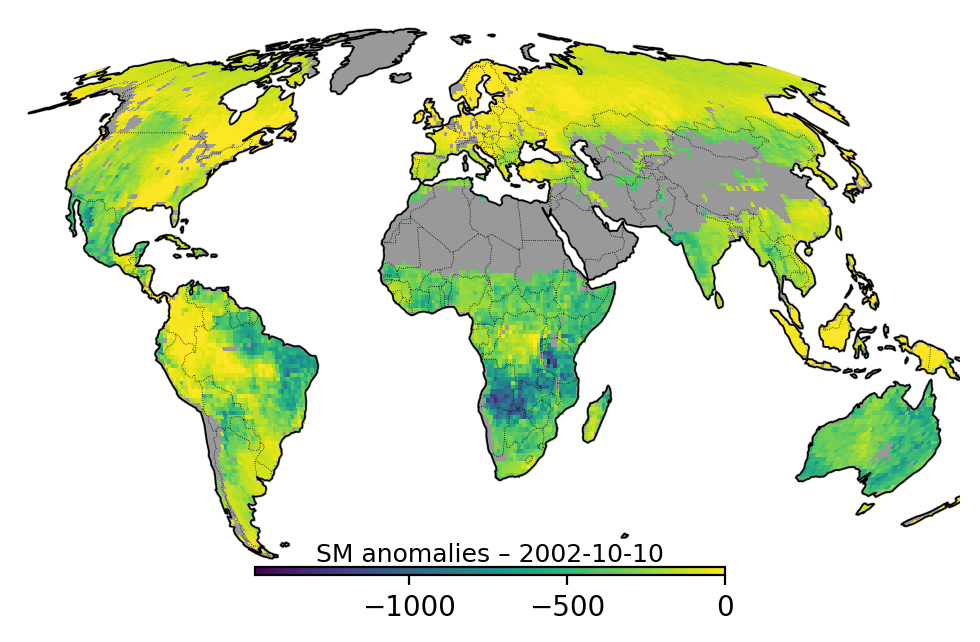

In [174]:

def make_figure(ncols=1, center=(0, 0)):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 4), subplot_kw={'projection': ccrs.Mollweide()}, squeeze=False, gridspec_kw={'wspace': 0})

    for ax in axes.flat:
        # generate a basemap with country borders, oceans and coastlines
        ax.add_feature(cfeat.LAND, color='0.6')
        #ax.add_feature(cfeat.OCEAN, color='0.4')
        ax.add_feature(cfeat.COASTLINE, lw=.6)
        ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.3)
        ax.set_global()
        ax.set_extent([-120, 150, -58, 90], crs=ccrs.PlateCarree())
    return fig, axes[0, :]

fig, axes = make_figure()

ax = axes[0]
ax.spines['geo'].set_visible(False)
ax.patch.set_visible(False)


img = ds.cwd.isel(time=0).plot.imshow(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=True,
    cbar_kwargs=dict(
        orientation='horizontal', pad=0.0, shrink=0.5, label='', aspect=60,
    )
)

img.colorbar.ax.set_title('SM anomalies – 2002-10-10', size=9, pad=0)

# cbax = inset_axes(ax,
#             width="100%",  # width = 50% of parent_bbox width
#             height="100%",  # height : 5%
#             loc='lower center',
#             bbox_to_anchor=(0.32, 0.0, 0.5, 0.02),
#             bbox_transform=ax.transAxes)

# cbax = ax.add_axes([0.32, 0.1, 0.5, 0.02])

# img.colorbar.remove()         
# cbar = fig.colorbar(img, cax=cbax, orientation='horizontal', extend='both')
# cbar.ax.set_title('SM anomalies – 2002-10-10', color='k', size=9)
# cbar.ax.tick_params(labelsize=9) 

ax.set_title('')

fig.tight_layout()

#fig.savefig('./test.png', dpi=300, transparent=True)

In [1]:
import xarray as xr
import math
from glob import glob

from dask.diagnostics import ProgressBar

In [9]:
ds2 = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/LST.hourly.1460.1140.2004.nc').chunk({'time': 50, 'latitude': -1, 'longitude': -1})
ds2

<xarray.Dataset>
Dimensions:    (time: 8784, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 ... 2004-12-31T23:00:00
  * longitude  (longitude) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    LST        (time, latitude, longitude) float32 dask.array<chunksize=(50, 1140, 1460), meta=np.ndarray>
Attributes: (12/14)
    CDI:                           Climate Data Interface version 2.0.5 (http...
    Conventions:                   CF-1.6
    title:                         FLand Surface Temperature product derived ...
    version:                       no-version-given
    reference:                     Trigo, I. F., C. C. DaCamara, P. Viterbo, ...
    provided_by:                   LST has been provided by the EUMETSAT Sate...
    ...                            ...
    created_by:                    uweber@bgc-jena.mpg.de
    spatial_interpolation_method:  bilinear
    CDO:                           Climate Data Operators version 2.0.5 (http...
    NCO:                           netCDF Operators version 5.0.7 (Homepage =...
    min_val:                       -60.0
    max_val:                       60.0

In [3]:
ds = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/LST.hourly.1460.1140.2004.nc').chunk({'time': 50, 'latitude': -1, 'longitude': -1})
ds

<xarray.Dataset>
Dimensions:    (time: 8784, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 ... 2004-12-31T23:00:00
  * longitude  (longitude) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    LST        (time, latitude, longitude) float32 dask.array<chunksize=(50, 1140, 1460), meta=np.ndarray>
Attributes: (12/14)
    CDI:                           Climate Data Interface version 2.0.5 (http...
    Conventions:                   CF-1.6
    title:                         FLand Surface Temperature product derived ...
    version:                       no-version-given
    reference:                     Trigo, I. F., C. C. DaCamara, P. Viterbo, ...
    provided_by:                   LST has been provided by the EUMETSAT Sate...
    ...                            ...
    created_by:                    uweber@bgc-jena.mpg.de
    spatial_interpolation_method:  bilinear
    CDO:                           Climate Data Operators version 2.0.5 (http...
    NCO:                           netCDF Operators version 5.0.7 (Homepage =...
    min_val:                       -60.0
    max_val:                       60.0

In [6]:
with ProgressBar():
    ds_min = ds.LST.min().compute()
    ds_min2 = ds2.LST.min().compute()


[########################################] | 100% Completed |  8min 47.3s
[########################################] | 100% Completed |  8min 35.3s


In [8]:
ds_min

<xarray.DataArray 'LST' ()>
array(-60., dtype=float32)

In [99]:
with ProgressBar():
    m = ds.LST.sel(time='2004-06-16T12').min().compute()

[########################################] | 100% Completed |  0.1s


In [11]:
diff = ds.LST.sel(time='2004-06-16T12') - ds2.LST.sel(time='2004-06-16T12')

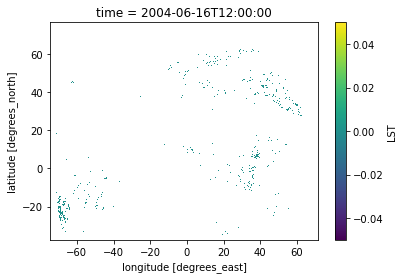

In [12]:
diff.plot()

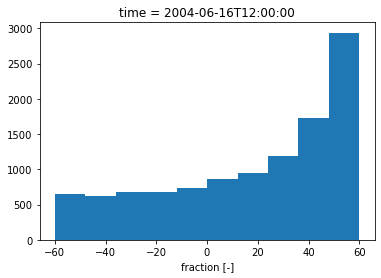

In [20]:
ds.LST.sel(time='2004-06-16T12').plot.hist();

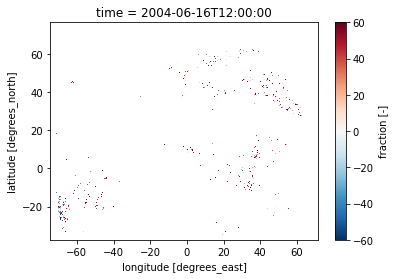

In [21]:
ds.LST.sel(time='2004-06-16T12').plot()

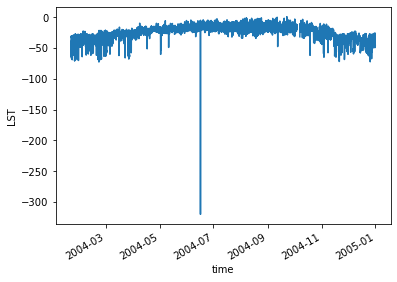

In [27]:
ds_min.plot()

In [33]:
!watch -n0.1 ls -lh /Net/Groups/BGI/scratch/bkraft/drought_data/preproc/

>-r--r-- 1 bkraft SBC  29G Jun  1 19:36 LST.hourly.1460.1140.2006.nca.mpg.de: Thu Jun  2 18:21:51 2022total 2.5T234567892:008

In [ ]:
chunks = [
    {'time': 50, 'latitude': 1000, 'longitude': 1000},
    {'time': 500, 'latitude': 1000, 'longitude': 1000},
    {'time': 50, 'latitude': -1, 'longitude': -1},
    {'time': 500, 'latitude': -1, 'longitude': -1},
]

for chunk in chunks:
    print(chunk)
    with ProgressBar():
        ds = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/LST.hourly.1460.1140.2004.nc').chunk(chunk)
        ds_mean = ds.LST.isel(time=slice(0, 1000)).mean(('latitude', 'longitude')).compute()

{'time': 50, 'latitude': 1000, 'longitude': 1000}
[########################################] | 100% Completed | 39.2s
{'time': 500, 'latitude': 1000, 'longitude': 1000}
[########################################] | 100% Completed |  1min  3.3s
{'time': 50, 'latitude': -1, 'longitude': -1}
[########################################] | 100% Completed | 37.1s
{'time': 500, 'latitude': -1, 'longitude': -1}
[########################################] | 100% Completed | 37.4s


CPU times: user 790 ms, sys: 133 ms, total: 923 ms
Wall time: 832 ms


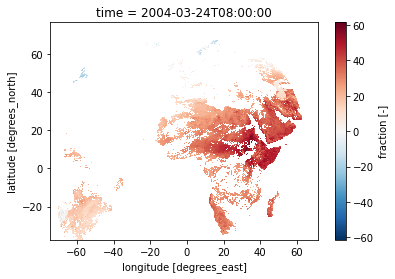

In [5]:
%%time

ds.LST.isel(time=2000).plot()

In [45]:
ds_mean = ds.LST.mean(('latitude', 'longitude')).compute()

KeyboardInterrupt: 

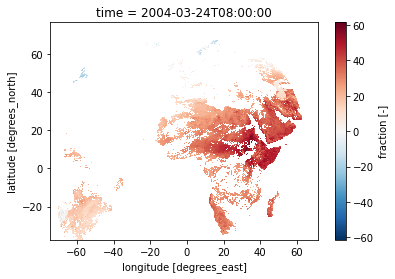

In [28]:
from glob import glob
glob('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0*_static/*')

In [71]:
wtd = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/WTD_Fan/v2013/Data/WTD.43200.21600.nc').isel(time=0)[['WTD']]
rd = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/MaxRootDepth/FAN_2017/Data/MaxRootDepth.FAN_2017.43200.000.21600.000.nc').rename({'MaxRrootDepth': 'rd'})
twi = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d00416_static/topidx_ga/v1/Data/topidxga2.nc').rename({'topidx': 'ti'})

In [83]:
twi

<xarray.Dataset>
Dimensions:    (longitude: 86400, latitude: 43200)
Coordinates:
  * longitude  (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * latitude   (latitude) float64 90.0 89.99 89.99 89.99 ... -89.99 -89.99 -90.0
Data variables:
    ti         (latitude, longitude) float32 ...
Attributes:
    title:          topographic index based on GA2 algorithmen
    provided_by:    Marthews, T.R.; Dadson, S.J.; Lehner, B.; Abele, S.; Gedn...
    reference:      https://doi.org/10.5285/6b0c4358-2bf3-4924-aa8f-793d468b92be
    created_by:     uweber@bgc-jena.mpg.de
    download_url:   https://catalogue.ceh.ac.uk/documents/6b0c4358-2bf3-4924-...
    version:        v1
    history:        file creation date: Thu Sep  7 09:49:28 2017
    documentation:  see ../Documentation/ and reference

In [28]:
wtd = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/wtd.static.1460.1140.nc').WTD
twi = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/twi.static.1460.1140.nc').topidx
mrd = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/mrd.static.1460.1140.nc').MaxRrootDepth

wtd.attrs["long_name"] = 'WTD'

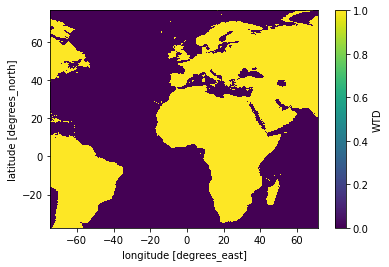

In [30]:
wtd.notnull().plot()

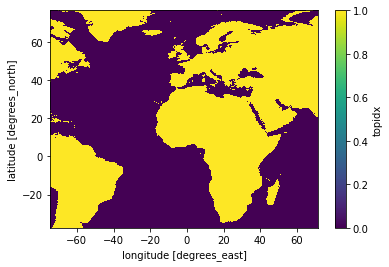

In [31]:
twi.notnull().plot()

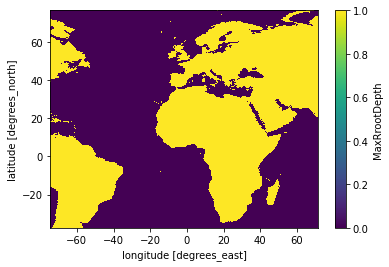

In [32]:
mrd.notnull().plot()

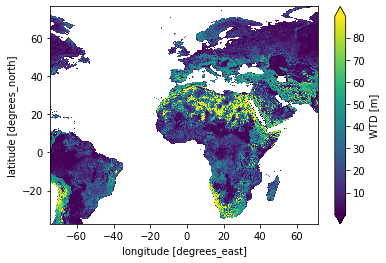

In [29]:
wtd.WTD.plot(robust=True)

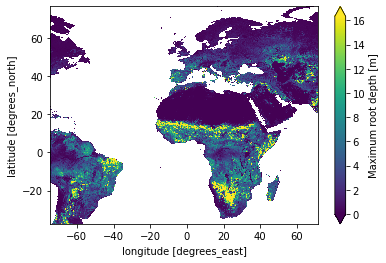

In [30]:
mrd.MaxRrootDepth.plot(robust=True)

In [74]:
wtd_r = wtd.coarsen(lat=12, lon=12).mean()

In [75]:
wtd_r

<xarray.Dataset>
Dimensions:  (lat: 1800, lon: 3600)
Coordinates:
    time     datetime64[ns] 2012-12-31
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat      (lat) float64 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
Data variables:
    WTD      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:           Global equilibrium Water Table Depth
    disclaimer:      These data can be used freely for research purposes prov...
    disclaimer2:     These data are made available in the hope that it will b...
    reference:       Fan Y., H. Li and G. Miguez-Macho (2013): Global pattern...
    provided_by:     Global Water Scarcity Information Service http://glowasi...
    contributed_by:  gonzalo.miguez@usc.es, hbli@eps.rutgers.edu
    institution:     Rutgers University and Universidade de Santiago de Compo...
    created_by:      uweber@bgc-jena.mpg.de
    experiment_id:   v2013
    source:          Africa_model_wtd.nc Australia_model_wtd.nc Eurasia_model...
    model_id:        v2013

In [8]:
t0

<xarray.Dataset>
Dimensions:    (time: 8784, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
  * longitude  (longitude) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun  1 20:19:40 2022: ncrcat -4 -O --cnk_plc g2d --cnk_...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...
    min_val:      222.80488844087964
    max_val:      319.37657165527344

In [9]:
wtd

<xarray.Dataset>
Dimensions:    (longitude: 1460, latitude: 1140)
Coordinates:
  * longitude  (longitude) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    WTD        (latitude, longitude) float32 ...
Attributes: (12/15)
    CDI:             Climate Data Interface version 2.0.5 (https://mpimet.mpg...
    Conventions:     CF-1.6
    source:          Africa_model_wtd.nc Australia_model_wtd.nc Eurasia_model...
    institution:     Rutgers University and Universidade de Santiago de Compo...
    title:           Global equilibrium Water Table Depth
    disclaimer:      These data can be used freely for research purposes prov...
    ...              ...
    contributed_by:  gonzalo.miguez@usc.es, hbli@eps.rutgers.edu
    created_by:      uweber@bgc-jena.mpg.de
    experiment_id:   v2013
    model_id:        v2013
    history:         Fri Jun 03 11:23:57 2022: cdo -O --reduce_dim remapcon,/...
    CDO:             Climate Data Operators version 2.0.5 (https://mpimet.mpg...

In [11]:
n = t0.isel(time=0)

In [16]:
n['wtd'] = wtd.WTD
n.wtd.attrs["long_name"] = 'WTD'

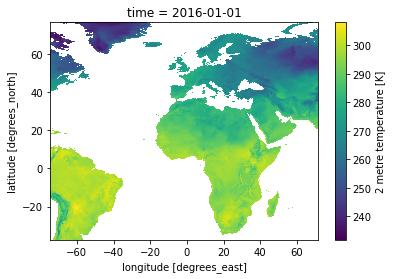

In [17]:
n.t2m.plot()

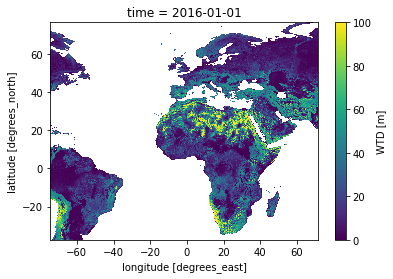

In [18]:
n.wtd.plot()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

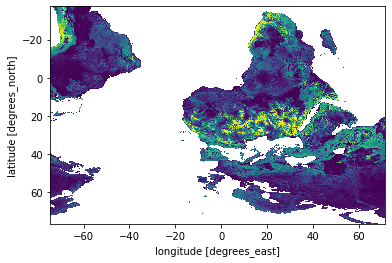

In [4]:
wtd.WTD.plot()

In [ ]:
0.1

In [49]:
0.0083 * 3

0.0249

In [58]:
0.1 / 0.0083

12.048192771084338

In [72]:
wtd

<xarray.Dataset>
Dimensions:  (lat: 21600, lon: 43200)
Coordinates:
    time     datetime64[ns] 2012-12-31
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 90.0 89.99 89.98 89.97 ... -89.97 -89.98 -89.99 -90.0
Data variables:
    WTD      (lat, lon) float32 ...
Attributes:
    title:           Global equilibrium Water Table Depth
    disclaimer:      These data can be used freely for research purposes prov...
    disclaimer2:     These data are made available in the hope that it will b...
    reference:       Fan Y., H. Li and G. Miguez-Macho (2013): Global pattern...
    provided_by:     Global Water Scarcity Information Service http://glowasi...
    contributed_by:  gonzalo.miguez@usc.es, hbli@eps.rutgers.edu
    institution:     Rutgers University and Universidade de Santiago de Compo...
    created_by:      uweber@bgc-jena.mpg.de
    experiment_id:   v2013
    source:          Africa_model_wtd.nc Australia_model_wtd.nc Eurasia_model...
    model_id:        v2013

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

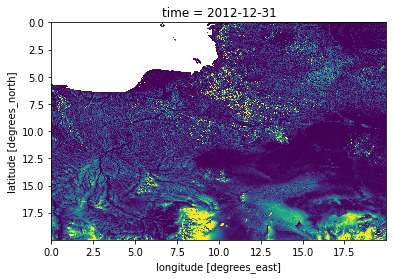

In [57]:
wtd.sel(lon=slice(0, 20), lat=slice(20, 0)).WTD.plot()

['/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0027_static/biomass',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d06_static/wetlands',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d01_static/PermafrostExtend',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d01_static/globland30',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/WTD_Fan',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/HWSD',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/continents',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/PZI',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/permeability',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/CMS_Global_Soil_Respiration',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/FAO_gez',
 '/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/MCD12Q1',


In [92]:
ch = xr.open_dataset('/Net/Groups/BGI/data/DataStructureMDI/DATA/grid/Global/0d0083_static/canopy_height/v_2005/Data/canopy_height.43200.21600.2005.nc')

In [96]:
ch

<xarray.Dataset>
Dimensions:        (time: 1, longitude: 43200, latitude: 21600)
Coordinates:
  * time           (time) datetime64[ns] 2005-12-31T23:59:00.000004
  * longitude      (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0
  * latitude       (latitude) float64 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
Data variables:
    canopy_height  (latitude, longitude) float32 ...
    error          (latitude, longitude) float32 ...
Attributes:
    history:      created: Fri Mar 10 16:25:14 2017
    created_by:   uweber@bgc-jena.mpg.de
    reference:    Simard, M., N. Pinto, J. B. Fisher, and A. Baccini (2011), ...
    provided_by:  JPL
    title:        canopy_height
    version:      v_2005
    more_info:    error at 1deg resolution

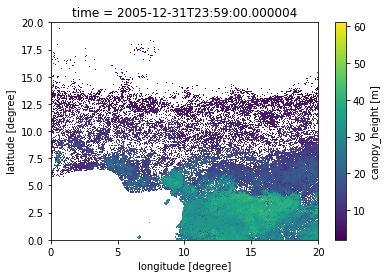

In [95]:
ch.isel(time=0).canopy_height.sel(latitude=slice(20, 0), longitude=slice(0, 20)).plot()

In [31]:
t0 = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/t2m.hourly.1460.1140.2016.nc')
t1 = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/t2m.hourly.1460.1140.2017.nc')

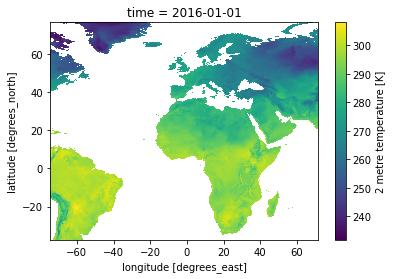

In [32]:
t0.t2m.isel(time=0).plot()

In [33]:
t0_m = t0.t2m.mean(('latitude', 'longitude'))
t1_m = t1.t2m.mean(('latitude', 'longitude'))
print(t0_m, t1_m)

<xarray.DataArray 't2m' (time: 8784)>
array([280.26846, 279.91922, 279.6188 , ..., 285.14517, 284.69098,
       284.27133], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00 <xarray.DataArray 't2m' (time: 1488)>
array([281.5131 , 281.16962, 280.86902, ..., 282.52106, 282.00064,
       281.52518], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00


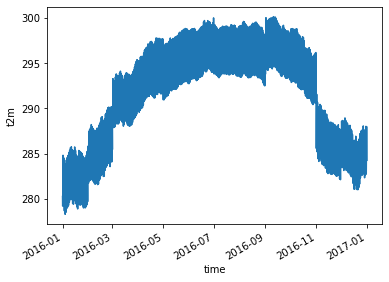

In [36]:
t0_m.plot()

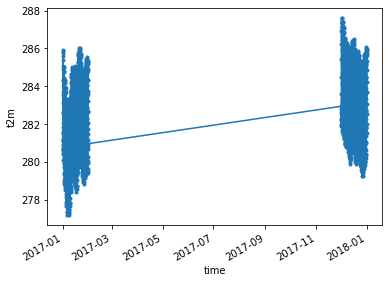

In [38]:
t1_m.plot(marker='.')

In [42]:
t1

<xarray.Dataset>
Dimensions:    (time: 1488, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
  * longitude  (longitude) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * latitude   (latitude) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
Data variables:
    t2m        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jun  1 20:20:22 2022: ncrcat -4 -O --cnk_plc g2d --cnk_...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 5.0.7 (Homepage = http://nco.sf.ne...
    min_val:      217.65512084960938
    max_val:      318.8758631310655

In [49]:
t0.time

<xarray.DataArray 'time' (time: 8784)>
array(['2016-01-01T00:00:00.000000000', '2016-01-01T01:00:00.000000000',
       '2016-01-01T02:00:00.000000000', ..., '2016-12-31T21:00:00.000000000',
       '2016-12-31T22:00:00.000000000', '2016-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    cell_methods:   time: mean

In [47]:
t1.time

<xarray.DataArray 'time' (time: 1488)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ..., '2017-12-31T21:00:00.000000000',
       '2017-12-31T22:00:00.000000000', '2017-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    cell_methods:   time: mean

## WTD, TWI, 

KeyboardInterrupt: 

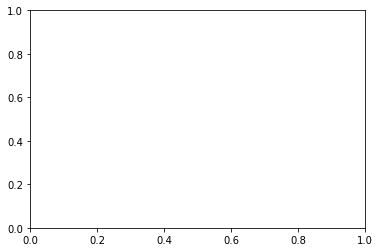

In [35]:
ds.topidx.plot()

In [1]:
import xarray as xr
import pandas as pd

In [7]:
ds = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/lst.hourly.1460.1140.2005.nc')

In [15]:
ds.time += pd.Timedelta(1, units='Y')

TypeError: Values of an IndexVariable are immutable and can not be modified inplace

In [8]:
ds.time - pd.Timedelta(f'{365 + 365 + 366}D')

<xarray.DataArray 'time' (time: 8760)>
array(['2002-01-01T00:00:00.000000000', '2002-01-01T01:00:00.000000000',
       '2002-01-01T02:00:00.000000000', ...,
       '2002-12-31T21:00:00.000000000', '2002-12-31T22:00:00.000000000',
       '2002-12-31T23:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01 ... 2005-12-31T23:00:00

In [11]:
years = range(2002, 2006)
vars = ['a', 'b', 'c']

In [16]:
paths = [f'{var}_{year}' for year in years for var in vars if ((var != 'b') or (year not in (2002, 2003)))]
paths

['a_2002',
 'c_2002',
 'a_2003',
 'c_2003',
 'a_2004',
 'b_2004',
 'c_2004',
 'a_2005',
 'b_2005',
 'c_2005']

In [7]:
import xarray as xr
import matplotlib.pyplot as plt

In [10]:
cube_d = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/cube.1460.1140.2002.2005.zarr', group='daily')

/scratch/tmp/ipykernel_162207/3759036851.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  cube_d = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/cube.1460.1140.2002.2005.zarr', group='daily')


GroupNotFoundError: group not found at path 'daily'

In [27]:
fvc

<xarray.Dataset>
Dimensions:    (time: 31, longitude: 1460, latitude: 1140)
Coordinates:
  * time       (time) datetime64[ns] 2004-10-01T00:00:00.000040 ... 2004-10-3...
  * longitude  (longitude) float64 -74.45 -74.35 -74.25 ... 71.25 71.35 71.45
  * latitude   (latitude) float64 76.45 76.35 76.25 ... -37.25 -37.35 -37.45
Data variables:
    LST        (time, latitude, longitude) float32 ...
Attributes:
    title:                         Fraction of Vegetation Cover product deriv...
    version:                       no-version-given
    reference:                     Trigo, I. F., C. C. DaCamara, P. Viterbo, ...
    provided_by:                   FVC has been provided by the EUMETSAT Sate...
    url:                           http://lsa-saf.eumetsat.int
    history:                       created: Mon May 16 08:19:11 2022
    created_by:                    uweber@bgc-jena.mpg.de
    spatial_interpolation_method:  bilinear

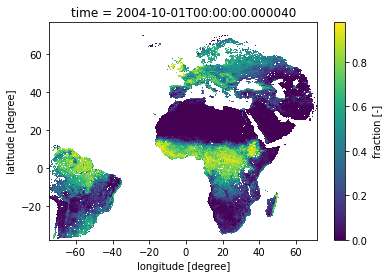

In [30]:
fvc.LST.sel(time='2004-04-11', method='nearest').plot()

In [4]:
ndvi = xr.Dataset()
time = slice('2000', '2010')
ndvi['obs'] = xr.open_dataset('/Net/Groups/BGI/people/bkraft/ndvi_memory/predictions/dense_alt/stacks00/obs.nc').sel(time=time).val
ndvi['mod'] = xr.open_dataset('/Net/Groups/BGI/people/bkraft/ndvi_memory/predictions/dense_alt/stacks00/shuffle-001/pred_rob.nc').sel(time=time).val
ndvi.load()

<xarray.Dataset>
Dimensions:  (time: 264, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-15 ... 2010-12-15
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Data variables:
    obs      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan
    mod      (lat, lon, time) float32 nan nan nan nan nan ... nan nan nan nan

In [8]:
animate(
    [ndvi.obs, ndvi.mod], vmin=[0.0, 0.0], vmax=[1.0, 1.0], title=['NDVI obs', 'NDVI mod'],
    cmap=['BrBG', 'BrBG'],
    save_path='./anim/ndvi', timerange=-1, globe=False,
    ncpus=24, dpi=200, fps=10, png_out=True)